<a href="https://colab.research.google.com/github/molesnathan1/Foreign-Aid-and-GPD-Growth/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Testing The Effectiveness of Foreign Aid
By Nathan Moles, Konstantine Jalagonia, Peter Maria, John Paci

In [339]:
%%capture
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
%pip install geopandas
import geopandas
%pip install mapclassify
import mapclassify
from scipy.stats import shapiro

!git clone https://molesnathan1.github.io/Foreign-Aid-and-GPD-Growth/

#Business Understanding

This project aims to assess the effectiveness of foreign aid in promoting growth, economic development, and prosperity. Investigating this question is important because despite the massive foreign aid flows from the west, developing countries remain extremely poor. By consolidating the knowledge from research done on this topic, it is possible to design a policy prescription that improves aid effectiveness.

For our project we decided to use per capita GDP growth as a measure of change in economic devevelopment. Other measure like total GDP can bias our results since they do not take into account the total population of the country. For example, nations with big population tend to have higher GDP levels but still suffer from poverty. On the other hand, per capita GDP shows the dollar amount of goods and services each citizen get on average. We acknowledge the fact that this is not a perfect measure. Least Develped Nations can have high inequality level; majority of the money is distributed among a small group of individuals with substantial political and financial power. We make a simplyfing assumption that countries don't suffere from high levels of inequality and the funds received as foreign aid are distributed approximately equally among the population.

There is a growing body of research showing that the effectiveness of aid in promoting prosperity depends on the quality of governance and proper allocation of funds between donors and recipients. Since the goal of our project is to assess the effectiveness of the way aid is distributed to developing countries, we will control for the quality of the governance in each country.

First, we will conduct exploratory data analysis to extract some non-obvious/actionable insights that aid distributing agencies can use in the future to improve the effectiveness of the aid. Finally, we will use a logistic regression to see if amount of foreign aid is a good predictor of the per capita GDP growth rate next year. We do not expect to get results implying that foreign aid does in fact promote economic prosperity in developing countries. We believe that the reasons why countries have low economic development levels are complex and just transfering funds to nations in not an effective method of solving those issues. Our project will contribute to the body of research trying to check the effectiveness of the steps taken by Western nations to combat hunger, underdevelopment, and economic destitution in poor countries.

#Data Understanding

**Data Information:**

All the datasets used in our analysis contain country level panel data. The data containing information about country's total GDP, per capita GDP growth rate, and the amount of foreign aid received each year comes from the World Bank's World Development Indicators dataset. The World Development Indicators is a compilation of relevant, high-quality, and internationally comparable statistics about global development and the fight against poverty. The database contains 1,400 time series indicators for 217 economies and more than 40 country groups, with data for many indicators going back more than 50 years. The data containing information about indices for different measure of quality of governance comes from the World Bank's Worldwide Governance Indicators project. WGI reports aggregate and individual governance indicators for over 200 countries and territories over the period 1996–2020, for six dimensions of governance: Voice and Accountability, Political Stability and Absence of Violence/Terrorism, Government Effectiveness,Regulatory Quality, Rule of Law, and Control of Corruption.

In [340]:
#@title GDP and Foreign Aid Data
import plotly.graph_objects as go

# colors of the rows
headerColor = 'green'
rowEvenColor = 'lightgreen'
rowOddColor = 'white'

# create a table figure
fig = go.Figure(data=[go.Table(
  columnorder = [1,2,3,4],
  columnwidth = [70,50,50,350],

  # header content and appearance
  header=dict(
    values=['<b>Attribute</b>','<b>Type</b>','<b>Nullable</b>','<b>Description</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left'],
    font=dict(color='white', size=11)
  ),

  # content and appearance of the cells in the table
  cells=dict(
    values=[
      ['Country','Code','Year','Foreign Aid', 'GDP', 'GDP Growth', 'Foreign Aid %'],
      ['Nominal','Nominal','Interval','Ratio','Ratio','Ratio','Ratio'],
      ['No','No','No','Yes','Yes','Yes','Yes'],
      ['Indicates country by name',
       'Indicates the country by a unique code', 
       'Indicates the year that the data is collected from',
       'The amount of foreign aid that a country recieved that year. This foreign aid is specifically the money that is given or lent to a country by another country.',
       'GDP is the total monetary or market value of all the finished goods and services produced within in the borders of a country.', 
       'The GDP (Growth Domestic Product) per capita growth as an annual percentage. Per capita means the GDP is divided by the midyear population of the country.',
       'The amount of foreign aid a country recieved in a year as a percentage of the country\'s gdp.']],
    line_color='darkslategray',
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor]*3],
    align = ['left'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

# display the table
fig.show()

In [341]:
#@title World Wide Governance Indicators
import plotly.graph_objects as go

# colors of the rows
headerColor = 'blue'
rowEvenColor = 'lightblue'
rowOddColor = 'white'

# create a table figure
fig = go.Figure(data=[go.Table(
  # size and order of columns
  columnorder = [1,2,3,4],
  columnwidth = [60,50,50,350],

  # header contents and appearance
  header=dict(
    values=['<b>Attribute</b>','<b>Type</b>','<b>Nullable</b>','<b>Description</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left'],
    font=dict(color='white', size=11)
  ),

  # content and appearance of the cells in the table
  cells=dict(
    values=[
      ['Country','Code','Year','Accountability','Stability','Effectiveneess','Quality','RuleLaw','Corruption'],
      ['Nominal','Nominal','Interval','Interval','Interval','Interval','Interval','Interval','Interval'],
      ['No','No','No','Yes','Yes','Yes','Yes','Yes','Yes'],
      ['Indicates country by name',
       'Indicates the country by a unique code', 
       'Indicates the year that the data is collected from',
       'Estimate perception of the extent to which a country\'s citizens are able to participate in selecting their government, as well as freedom of expression, freedom of association, and a free media. Ranges from approximately -2.5 (weak) to 2.5 (strong) governance performance.',
       'Estimate Political Stability and Absence of Violence/Terrorism measures perceptions of the likelihood of political instability and/or politically-motivated violence, including terrorism. Ranges from approximately -2.5 (weak) to 2.5 (strong) governance performance.',
       'Estimate perceptions of the quality of public services, the quality of the civil service and the degree of its independence from political pressures, the quality of policy formulation and implementation, and the credibility of the government\'s commitment to such policies. Ranges from approximately -2.5 (weak) to 2.5 (strong) governance performance.',
       'Estimate perceptions of the ability of the government to formulate and implement sound policies and regulations that permit and promote private sector development. Ranges from approximately -2.5 (weak) to 2.5 (strong) governance performance.',
       'Estimate perceptions of the extent to which agents have confidence in and abide by the rules of society, and in particular the quality of contract enforcement, property rights, the police, and the courts, as well as the likelihood of crime and violence. Ranges from approximately -2.5 (weak) to 2.5 (strong) governance performance.',
       'Estimate perceptions of the extent to which public power is exercised for private gain, including both petty and grand forms of corruption, as well as "capture" of the state by elites and private interests. Ranges from approximately -2.5 (weak) to 2.5 (strong) governance performance.']],
    line_color='darkslategray',
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor]*3],
    align = ['left'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

# display the table
fig.show()

#Data Preperation

Before starting the data analysis we prepare and clean the datasets. We uploaded the World Bank data to the Github repository. Economic data gets updated on a regular basis and we want to make sure that the data will be compatable with our project.

In [342]:
# github raw data urls
url1 = 'https://raw.githubusercontent.com/molesnathan1/Foreign-Aid-and-GPD-Growth/main/Data/GDP.csv'
url2 = 'https://raw.githubusercontent.com/molesnathan1/Foreign-Aid-and-GPD-Growth/main/Data/Aid.csv'
url3 = 'https://raw.githubusercontent.com/molesnathan1/Foreign-Aid-and-GPD-Growth/main/Data/wgidataset.xlsx'
url4 = 'https://raw.githubusercontent.com/molesnathan1/Foreign-Aid-and-GPD-Growth/main/Data/totalgdp.csv'

# read raw data into data frames
gdp = pd.read_csv(url1,na_values='..')
aid = pd.read_csv(url2, na_values='..')
totalgdp = pd.read_csv(url4, na_values='..')

# convert all of the csvs in the sxcel sheet in url 3 into dataframes
accountability = pd.read_excel(url3, sheet_name=1)
stability = pd.read_excel(url3, sheet_name=2)
effectiveness = pd.read_excel(url3, sheet_name=3)
quality = pd.read_excel(url3, sheet_name=4)
ruleLaw = pd.read_excel(url3, sheet_name=5)
corruption = pd.read_excel(url3, sheet_name=6)



We clean the data by dropping extra variables that are not relevant for our analysis. We also reshape the governance indicators data from wide to long format.

In [343]:
# reshapes a file from the excel sheet to be usable
pd.options.mode.chained_assignment = None

def reshape(df, val_name):
  headers = list(df.iloc[13])
  df.columns = headers
  df.drop(df.index[:12],axis=0,inplace=True)
  dropcolumns = ['StdErr','NumSrc','Rank', 'Lower',	'Upper']
  df = df.drop(dropcolumns, axis=1)
  newheaders = list(df.iloc[0])
  newheaders[0], newheaders[1] = 'Country', 'Code'
  df.columns = newheaders
  df.drop(index=df.index[0:2], axis=0,inplace=True)
  df = df.melt(id_vars=['Country','Code'],value_name = val_name,var_name='Year')
  return df

# reshape all csvs in the excel fi
accountability = reshape(accountability, "Accountability")
stability = reshape(stability, "Stability")
effectiveness = reshape(effectiveness, "Effectiveness")
quality = reshape(quality, "Quality")
ruleLaw = reshape(ruleLaw, "RuleLaw")
corruption = reshape(corruption, "Corruption")

We clean the World Bank's Development Indicators data. We drop the unnecessary variables also make sure that all variables are numeric to ensure the correctness of our analysis.

Macroeconomic theory argues that there is a one year lag between two related events. The foreign aid recieved in a particular year will not be distributed until the following period. To account for this we lag the foreign aid by one period.

In [344]:
#GDP
# drop uneeded columns
gdp = gdp.drop('Series Code', axis=1)
gdp = gdp.drop('Series Name', axis=1)
gdp = gdp[:217]
# save headers and rename the first 2
headers1 = list(gdp.columns.str.split().str[0])
headers1
headers1[0] = 'Country'
headers1[1] = 'Code'
gdp.columns = headers1
# flip rows and columns
gdp = gdp.melt(id_vars=['Country','Code'],value_name ='GDP Growth',var_name='Year')
# convert to numeric values
gdp['Year'] = pd.to_numeric(gdp['Year'])
gdp['GDP Growth'] = pd.to_numeric(gdp['GDP Growth'])


#total GDP
# drops uneeded columns
totalgdp = totalgdp.drop('Series Code', axis=1)
totalgdp = totalgdp.drop('Series Name', axis=1)
totalgdp = totalgdp[:217]
# save headers and rename the first 2
headers1 = list(totalgdp.columns.str.split().str[0])
headers1
headers1[0] = 'Country'
headers1[1] = 'Code'
totalgdp.columns = headers1
# flip rows and columns
totalgdp = totalgdp.melt(id_vars=['Country','Code'],value_name ='GDP',var_name='Year')
# convert to numeric values
totalgdp['Year'] = pd.to_numeric(totalgdp['Year'])
totalgdp['GDP'] = pd.to_numeric(totalgdp['GDP'])


#Aid
# drops uneeded columns
aid = aid.drop('Series Code', axis=1)
aid = aid.drop('Series Name', axis=1)
aid = aid[:217]
# save headers and rename the first 2
headers1 = list(aid.columns.str.split().str[0])
headers1
headers1[0] = 'Country'
headers1[1] = 'Code'
aid.columns = headers1
# flip rows and columns
aid = aid.melt(id_vars=['Country','Code'],value_name ='Foreign Aid',var_name='Year')
# convert to numeric values
aid['Year'] = pd.to_numeric(aid['Year'])
aid['Foreign Aid'] = pd.to_numeric(aid['Foreign Aid'])


#Lag the foreign aid
aid['Year'] = aid['Year'] + 1

We merge all datasets together on year and the country code. We drop the rows that contain at least one missing value. We make a copy of the created dataframe. We will use the copy of the data to avoid changing the intial dataset.

Our merged dataframe contains information about total GDP for each country and the lagged amount of foreign aid recieved. Since we want to check the effect of foreign aid on the economic performance, we believe that it will be relevant to calculate the foreign aid as a percent of GDP and use it as our main independent variable.

In [345]:
# merge all of the governance data into one frame by code, year, and country
outer_merged = accountability.merge(
    stability, how="left", on= ['Code', 'Year','Country']
)
outer_merged = outer_merged.merge(
    effectiveness, how="left", on= ['Code', 'Year','Country']
)
outer_merged = outer_merged.merge(
    quality, how="left", on= ['Code', 'Year','Country']
)
outer_merged = outer_merged.merge(
    ruleLaw, how="left", on= ['Code', 'Year','Country']
)
outer_merged = outer_merged.merge(
    corruption, how="left", on= ['Code', 'Year','Country']
)

# converts values to numerics
outer_merged[['Accountability','Stability','Effectiveness','Quality','RuleLaw','Corruption']] = outer_merged[['Accountability','Stability','Effectiveness','Quality','RuleLaw','Corruption']].apply(pd.to_numeric)
# merges gdp, aid, and totalgdp
gdp_aid = gdp.merge(aid, how="left", on= ['Code', 'Year','Country'])
gdpcombined = gdp_aid.merge(totalgdp, how="left", on= ['Code', 'Year','Country'])
data = outer_merged.merge(gdpcombined, how="left", on= ['Code', 'Year'])
data = data.drop('Country_y', axis=1)
# drop null values 
data = data.dropna(subset=['GDP'])
data = data.dropna(subset=['GDP Growth'])
data = data.dropna(subset=['Accountability'])
data = data.dropna(subset=['Foreign Aid'])
data = data.dropna(subset=['Effectiveness'])
data = data.dropna(subset=['Stability'])
data = data.dropna(subset=['Quality'])
data = data.dropna(subset=['RuleLaw'])
data = data.dropna(subset=['Corruption'])

# the cleaned data
clean_data = data.copy()
# calculates the foreign aid % column
clean_data['Foreign Aid %'] = (clean_data['Foreign Aid'] / clean_data['GDP'])*100

# Exploratory Data Analysis

We start the exploratory data analysis part of our project where we try to find actionable insights from the data

### Distibution

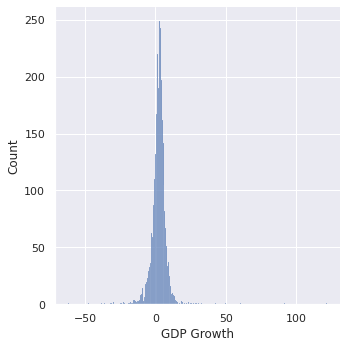

In [346]:
# create plot of gdp growth
sns.displot(data = clean_data, x = 'GDP Growth')
plt.show();

Outliers we focus on range between -15 and 15

(-15.0, 15.0)

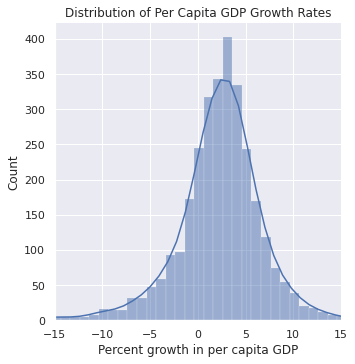

In [347]:
# plot the distribution of the gdp growth rate
f1 = sns.displot(clean_data['GDP Growth'],binwidth=1, kde=True);
f1.set(title='Distribution of Per Capita GDP Growth Rates', xlabel = 'Percent growth in per capita GDP');
plt.xlim(-15,15)

Focusing on a smaller subset of the data, GDP growth has a nice bell shape. Some countries have increase in GDP while proportionally some countries have decrease in GDP

In [348]:
#print summary statistics
clean_data['GDP Growth'].describe()

count    3064.000000
mean        2.314325
std         6.140283
min       -62.378047
25%         0.238031
50%         2.609854
75%         4.707579
max       121.779472
Name: GDP Growth, dtype: float64

In [349]:
#perform Shapiro-Wilk normality test
shapiro(clean_data['GDP Growth'])

(0.7215554714202881, 0.0)

The distribution of per capita GDP growth rates does not seem to be normally distributed. We conduct the Shapiro-Wilk normality test to check the validity of our assumption. P-value is equal to zero implying that we can not assert the normality of the distribution. The minimum per capita GDP growth rate in our data is -62.37% and a maximum value is 121.79%, with a mean of 2.31% and median of 2.61%.

(0.0, 2000000000.0)

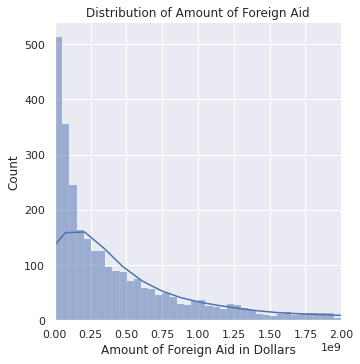

In [350]:
# plot the distribution of the Foreign Aid
f2 = sns.displot(clean_data['Foreign Aid'], binwidth=50000000, kde=True);
f2.set(title='Distribution of Amount of Foreign Aid', xlabel = 'Amount of Foreign Aid in Dollars');
plt.xlim(0, 2000000000)

For this distribution we are only focusing on countries who receive foreign aid, thus we are looking at the positive x axis. From this distribution we can see most countries receive no foreign aid while some countries receive massive amounts of aid.

In [351]:
#print summary statistics
clean_data['Foreign Aid'].describe()

count    3.064000e+03
mean     5.773603e+08
std      1.018820e+09
min     -9.976800e+08
25%      7.576000e+07
50%      2.542350e+08
75%      6.909050e+08
max      2.567156e+10
Name: Foreign Aid, dtype: float64

In [352]:
#perform Shapiro-Wilk normality test
shapiro(clean_data['Foreign Aid'])

(0.5250900387763977, 0.0)

The distribution of the foreign aid recieved by countries does not seem to be normally distributed. We conduct the Shapiro-Wilk normality test to check the validity of our assumption. P-value is equal to zero implying that we can not assert the normality of the distribution. The minimum foreign aid recieved by a country is -9.97 * 10^8. The negative value of foreign aid means that the country is giving foreign aid to others. The maximum value is 2.56 * 10^8, with a mean of 5.77 * 10^8 and median of 2.54 * 10^8.

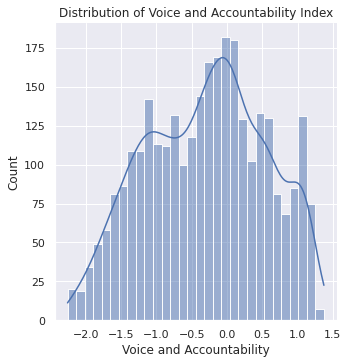

In [353]:
# plot the distribution of the Accountability
f3 = sns.displot(clean_data['Accountability'],bins=30, kde=True);
f3.set(title='Distribution of Voice and Accountability Index', xlabel = 'Voice and Accountability');

For the following distributions, they range approximately between -2.5 and 2.5. This is ordinal data. Surprisingly, no countries score highly on the voice and accountability index.

In [354]:
#print summary statistics
clean_data['Accountability'].describe()

count    3064.000000
mean       -0.304691
std         0.844784
min        -2.259159
25%        -0.984652
50%        -0.245705
75%         0.336318
max         1.372729
Name: Accountability, dtype: float64

In [355]:
#perform Shapiro-Wilk normality test
shapiro(clean_data['Accountability'])

(0.9795287847518921, 1.2849847727021379e-20)

The distribution of Voice and Accountability index does not seem to be normally distributed. The distribution is skewed to left. We conduct the Shapiro-Wilk normality test to check the validity of our assumption. P-value is close to zero implying that we can not assert the normality of the distribution. The minimum Voice and Accountability index in our data is -2.26 and a maximum value is 1.37, with a mean of -0.3 and median of -0.24.

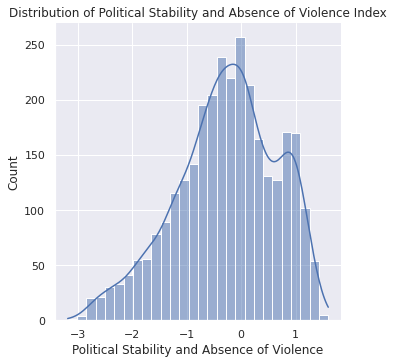

In [356]:
# plot the distribution of the stability
f4 = sns.displot(clean_data['Stability'], kde=True);
f4.set(title='Distribution of Political Stability and Absence of Violence Index', xlabel = 'Political Stability and Absence of Violence');

Similarly for the distribution of political stability scores, it is skewed left and not many countries score highly on this metric

In [357]:
#print summary statistics
clean_data['Stability'].describe()

count    3064.000000
mean       -0.274349
std         0.922017
min        -3.180798
25%        -0.844138
50%        -0.227636
75%         0.396843
max         1.599426
Name: Stability, dtype: float64

In [358]:
#perform Shapiro-Wilk normality test
shapiro(clean_data['Stability'])

(0.9802382588386536, 2.9966446534368994e-20)

The distribution of Political Stability and Absence of Violence index does not seem to be normally distributed. The distribution is skewed to left. We conduct the Shapiro-Wilk normality test to check the validity of our assumption. P-value is close to zero implying that we can not assert the normality of the distribution. The minimum value of Political Stability and Absence of Violence index in our data is -3.18 and a maximum value is 1.60, with a mean of -0.27 and median of -0.23.

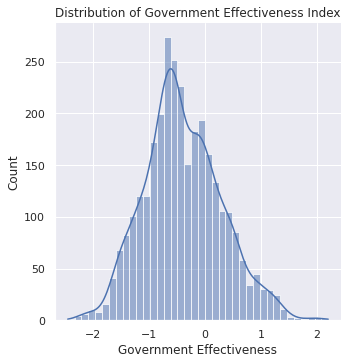

In [359]:
# plot the distribution of the effectiveness
f5 = sns.displot(clean_data['Effectiveness'], kde=True);
f5.set(title='Distribution of Government Effectiveness Index', xlabel = 'Government Effectiveness');

Government effectiveness distribution still has a little bit of a left skew, but it has a better bell shape than previous two distributions


In [360]:
#print summary statistics
clean_data['Effectiveness'].describe()

count    3064.000000
mean       -0.392054
std         0.688152
min        -2.446712
25%        -0.844413
50%        -0.461585
75%         0.053651
max         2.199069
Name: Effectiveness, dtype: float64

In [361]:
#perform Shapiro-Wilk normality test
shapiro(clean_data['Effectiveness'])

(0.9935861825942993, 2.208817018178877e-10)

The distribution of the Government Effectiveness index does not seem to be normally distributed. We conduct the Shapiro-Wilk normality test to check the validity of our assumption. P-value is close to zero implying that we can not assert the normality of the distribution. The minimum value of the Government Effectiveness index in our data is -2.44 and a maximum value is 2.20, with a mean of -0.39 and median of -0.46.

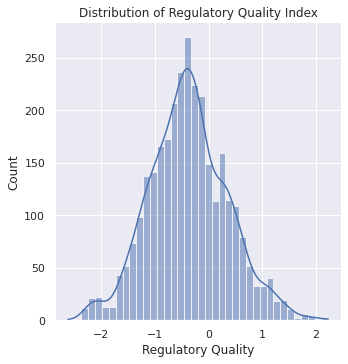

In [362]:
# plot the distribution of the quality
f6 = sns.displot(clean_data['Quality'], kde=True);
f6.set(title='Distribution of Regulatory Quality Index', xlabel = 'Regulatory Quality');

In [363]:
#print summary statistics
clean_data['Quality'].describe()

count    3064.000000
mean       -0.373677
std         0.729031
min        -2.625506
25%        -0.855125
50%        -0.396684
75%         0.091044
max         2.230809
Name: Quality, dtype: float64

In [364]:
#perform Shapiro-Wilk normality test
shapiro(clean_data['Quality'])

(0.9966382384300232, 2.434804628137499e-06)

The distribution of the Regulatory Quality index does not seem to be normally distributed. We conduct the Shapiro-Wilk normality test to check the validity of our assumption. P-value is close to zero implying that we can not assert the normality of the distribution. The minimum Regulatory Quality index in our data is -2.62 and a maximum value is 2.23, with a mean of -0.37 and median of -0.39.

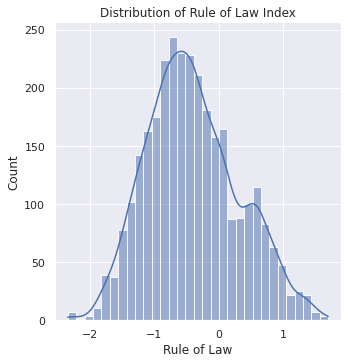

In [365]:
# plot the distribution of the rule law
f7 = sns.displot(clean_data['RuleLaw'], kde=True);
f7.set(title='Distribution of Rule of Law Index', xlabel = 'Rule of Law');

In [366]:
#print summary statistics
clean_data['RuleLaw'].describe()

count    3064.000000
mean       -0.402307
std         0.712823
min        -2.350949
25%        -0.906148
50%        -0.476138
75%         0.059737
max         1.707485
Name: RuleLaw, dtype: float64

In [367]:
#perform Shapiro-Wilk normality test
shapiro(clean_data['RuleLaw'])

(0.9879369735717773, 1.7762992411598372e-15)

The distribution of the Rule of Law index does not seem to be normally distributed. We conduct the Shapiro-Wilk normality test to check the validity of our assumption. P-value is close to zero implying that we can not assert the normality of the distribution. The minimum value of the Rule of Law index in our data is -2.35 and a maximum value is 1.70, with a mean of -0.40 and median of -0.47.

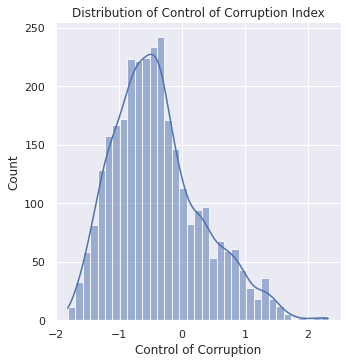

In [368]:
# plot the distribution of the corruption
f8 = sns.displot(clean_data['Corruption'], kde=True);
f8.set(title='Distribution of Control of Corruption Index', xlabel = 'Control of Corruption');

In [369]:
#print summary statistics
clean_data['Corruption'].describe()

count    3064.000000
mean       -0.394265
std         0.704970
min        -1.815811
25%        -0.891977
50%        -0.480427
75%        -0.016085
max         2.325580
Name: Corruption, dtype: float64

In [370]:
#perform Shapiro-Wilk normality test
shapiro(clean_data['Corruption'])

(0.9667193293571472, 4.777887373527489e-26)

The distribution of the Control of Corruption index does not seem to be normally distributed. We conduct the Shapiro-Wilk normality test to check the validity of our assumption. P-value is close to zero implying that we can not assert the normality of the distribution. The minimum value of the Control of Corruption index in our data is -1.81 and a maximum value is 2.32, with a mean of -0.39 and median of -0.48.

(0.0, 20.0)

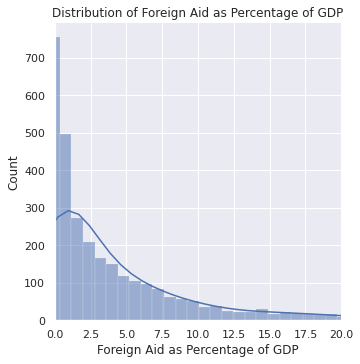

In [371]:
# plot the distribution of the foreign aid %
f9 = sns.displot(clean_data['Foreign Aid %'], kde=True);
f9.set(title='Distribution of Foreign Aid as Percentage of GDP', xlabel = 'Foreign Aid as Percentage of GDP');
plt.xlim(0,20 )

In [372]:
#print summary statistics
clean_data['Foreign Aid %'].describe()

count    3064.000000
mean        5.322980
std         9.576273
min        -1.254964
25%         0.365406
50%         1.999234
75%         6.240850
max       144.848831
Name: Foreign Aid %, dtype: float64

In [373]:
#perform Shapiro-Wilk normality test
shapiro(clean_data['Foreign Aid %'])

(0.5498738288879395, 0.0)

The distribution of the Foreign Aid as a Percent of GDP is not normally distributed. We conduct the Shapiro-Wilk normality test to check the validity of our assumption. P-value is zero implying that we can not assert the normality of the distribution. The minimum value of the Foreign Aid as a Percent of GDP in our data is -1.25% and a maximum value is 144.84%, with a mean of 4.32% and median of 2.00%.

###World Maps
We create the world maps for each year based on the per capita GDP growth rate and the level of the foreign aid received. We want to check if some interesting patterns emerge in data over time. We also want to check our hypothesis that there is no relationship between foreign aid and economic performace.

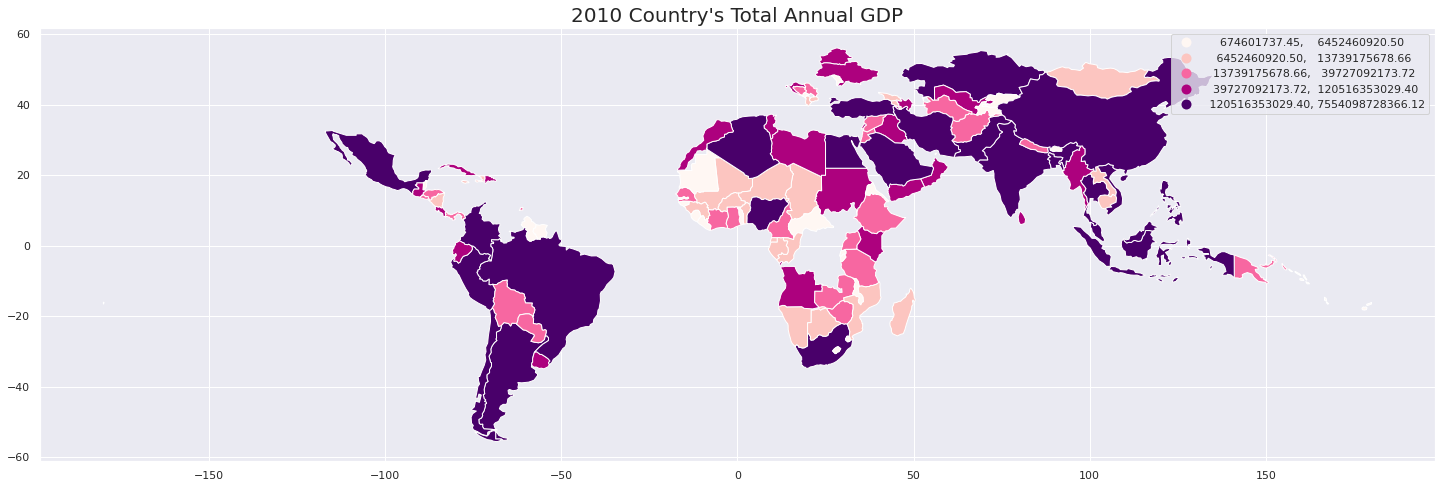

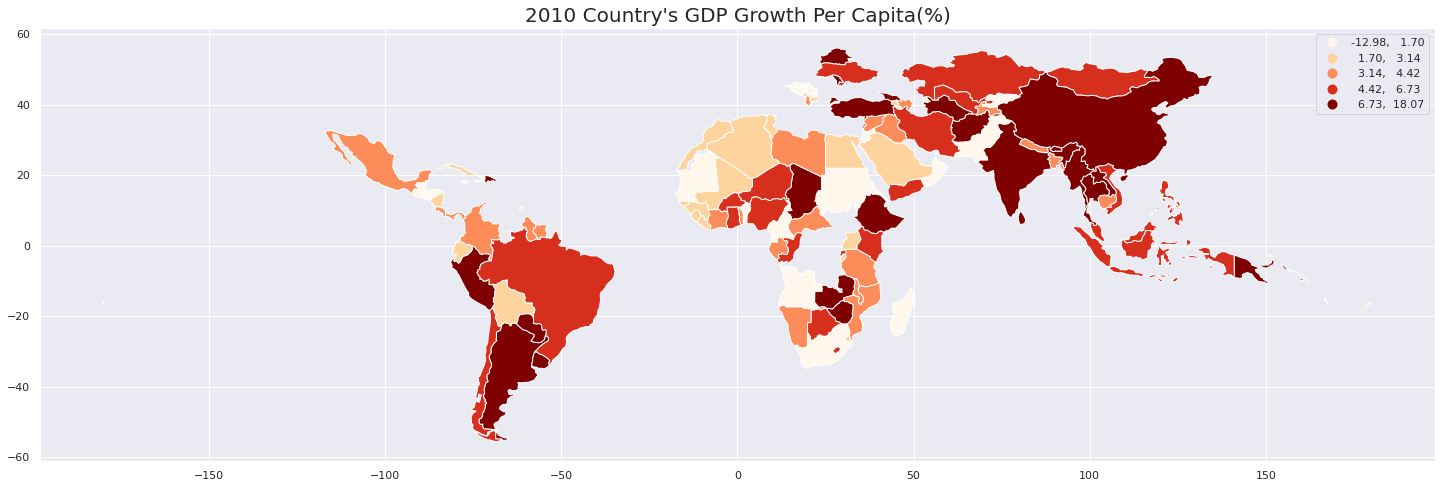

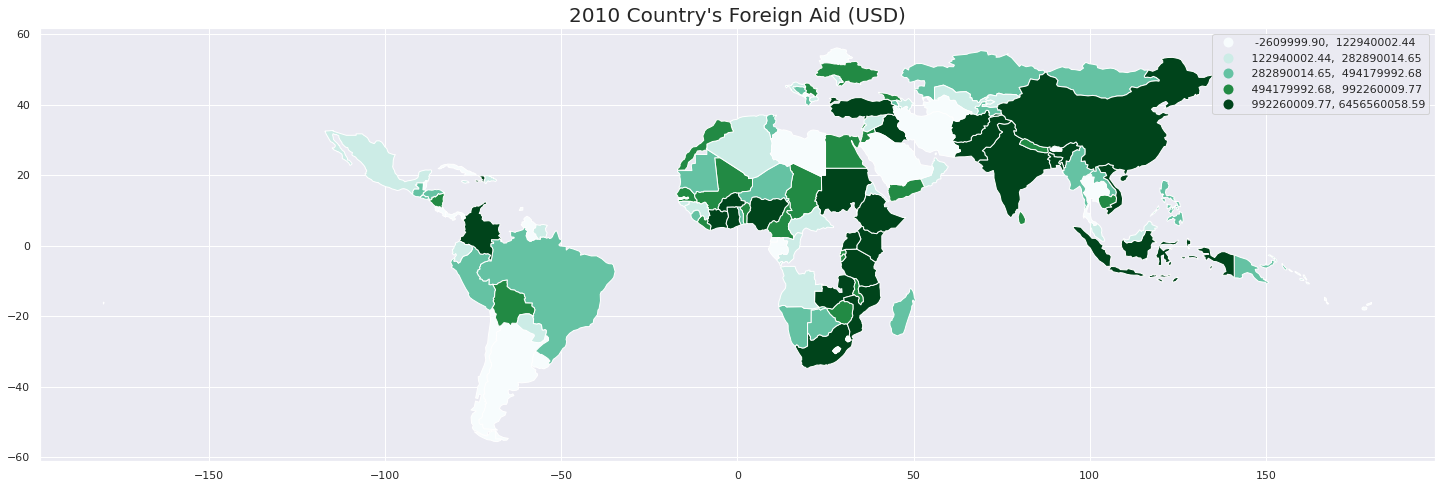

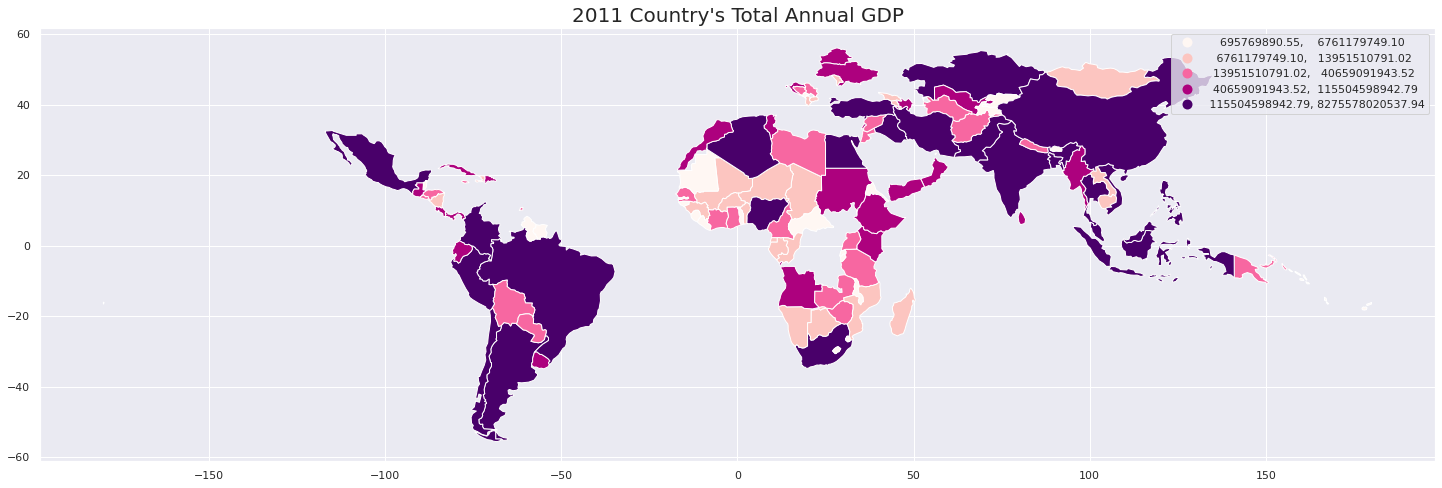

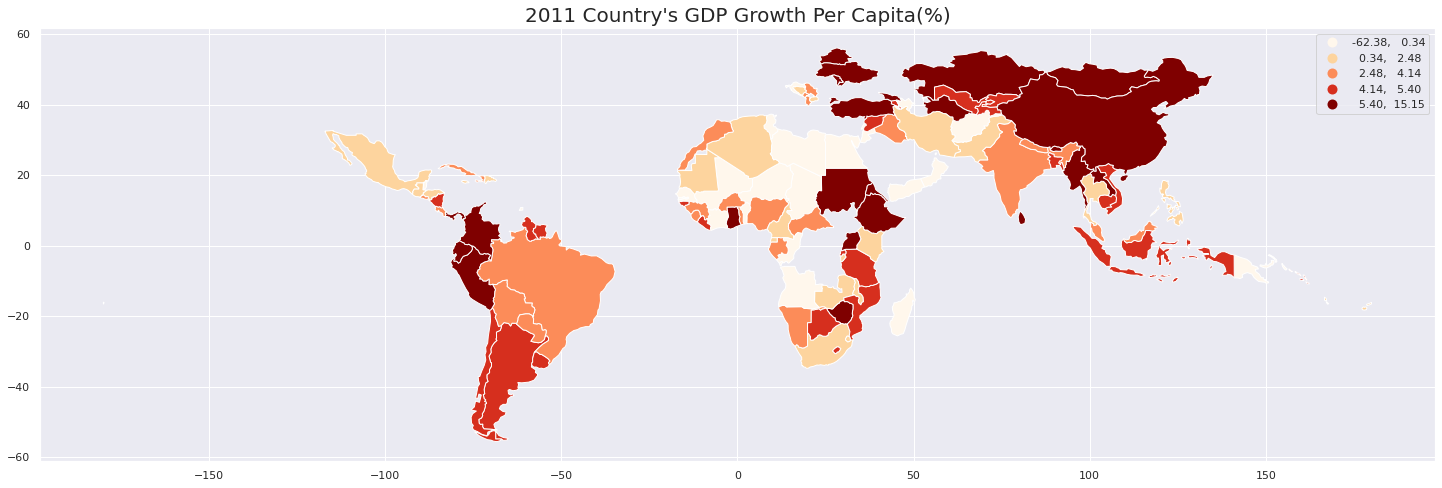

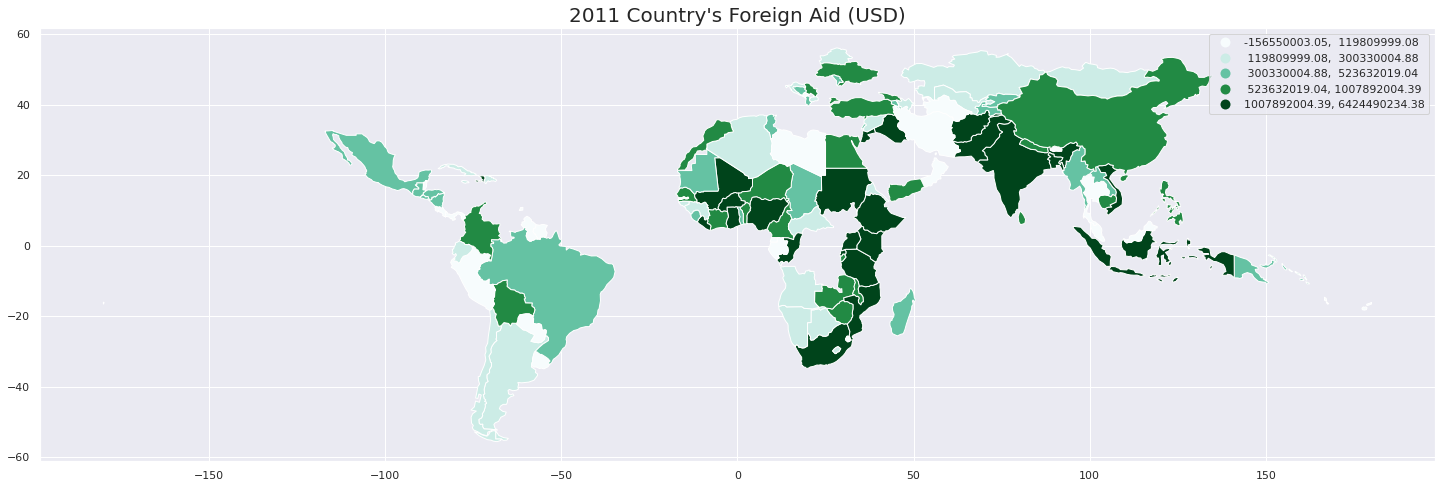

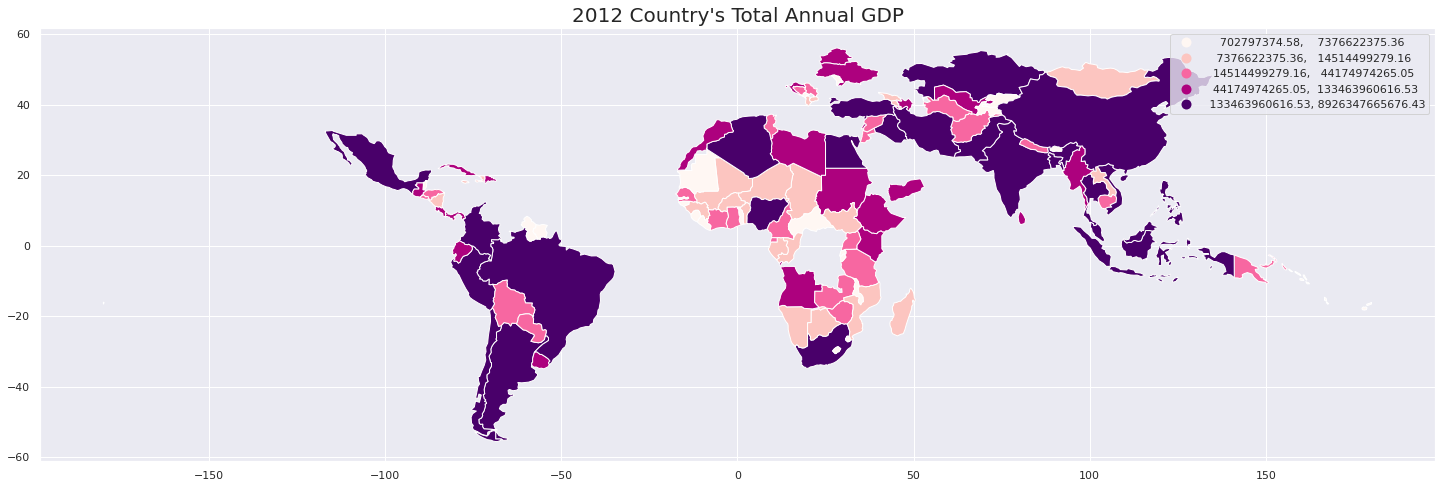

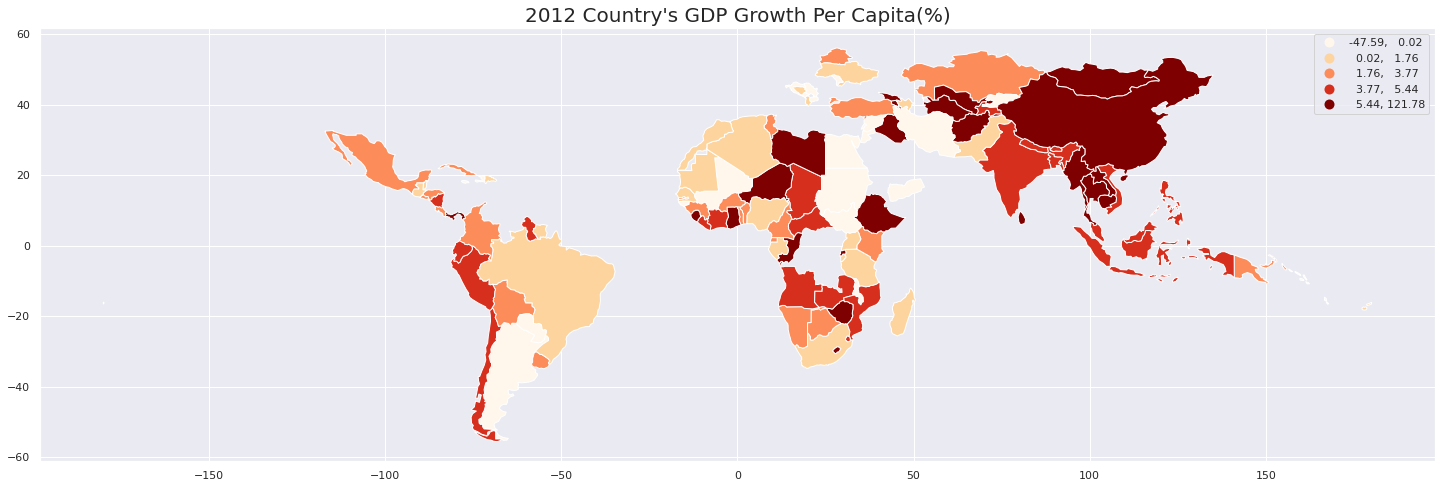

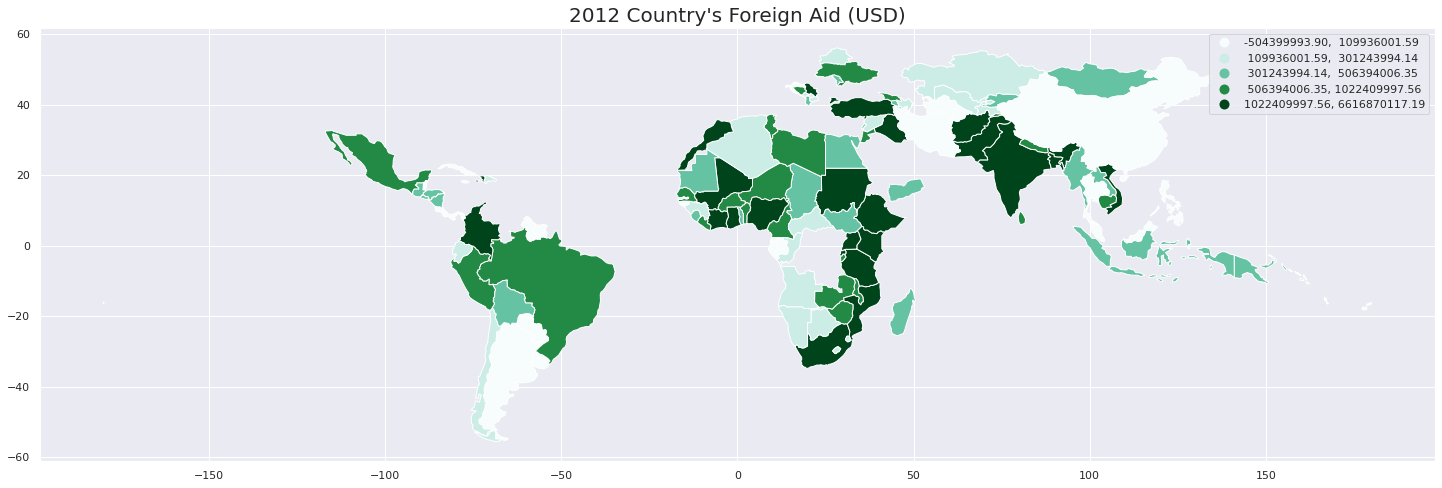

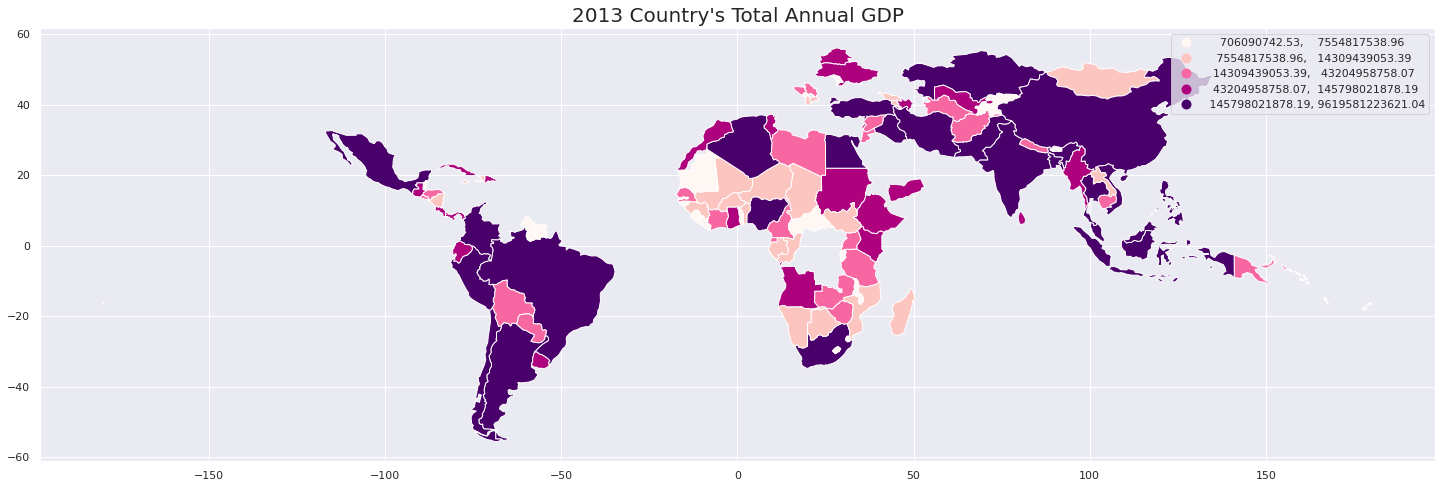

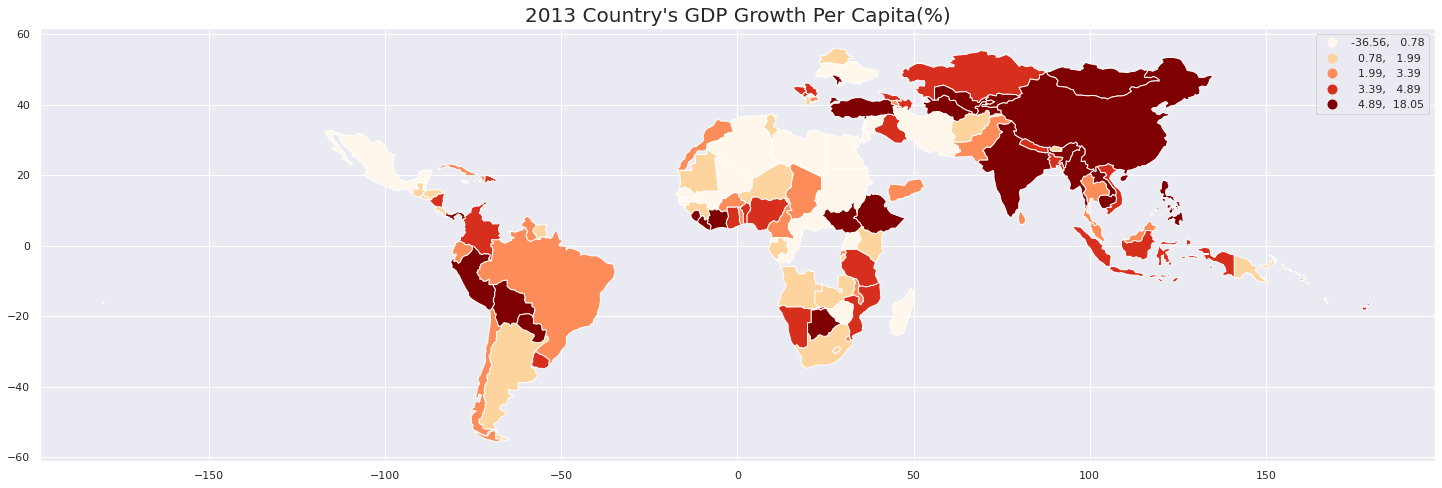

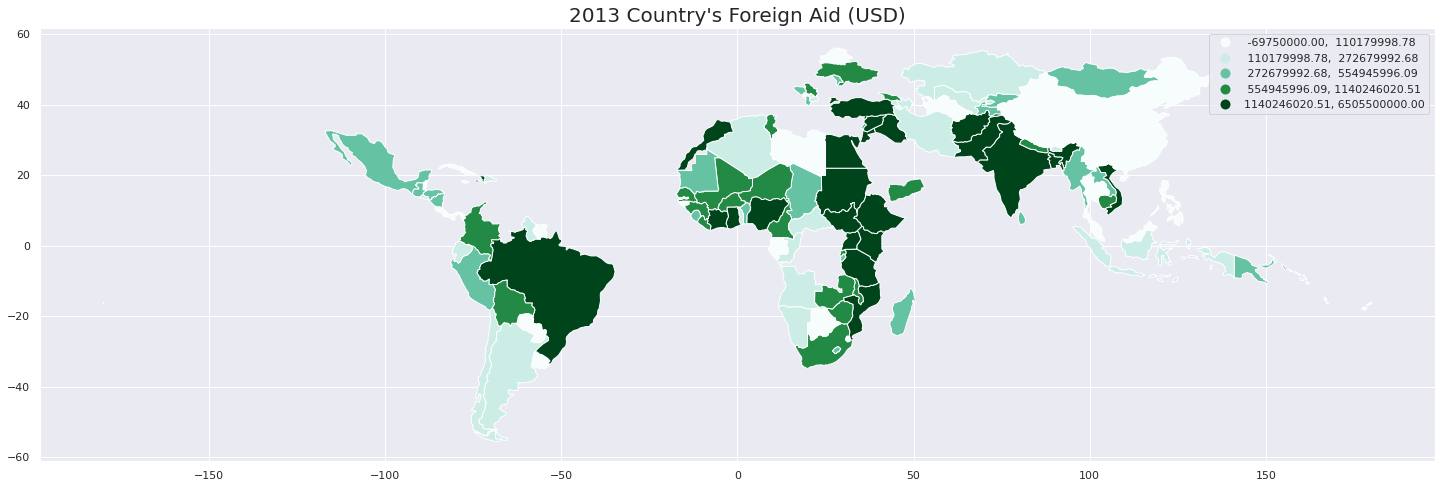

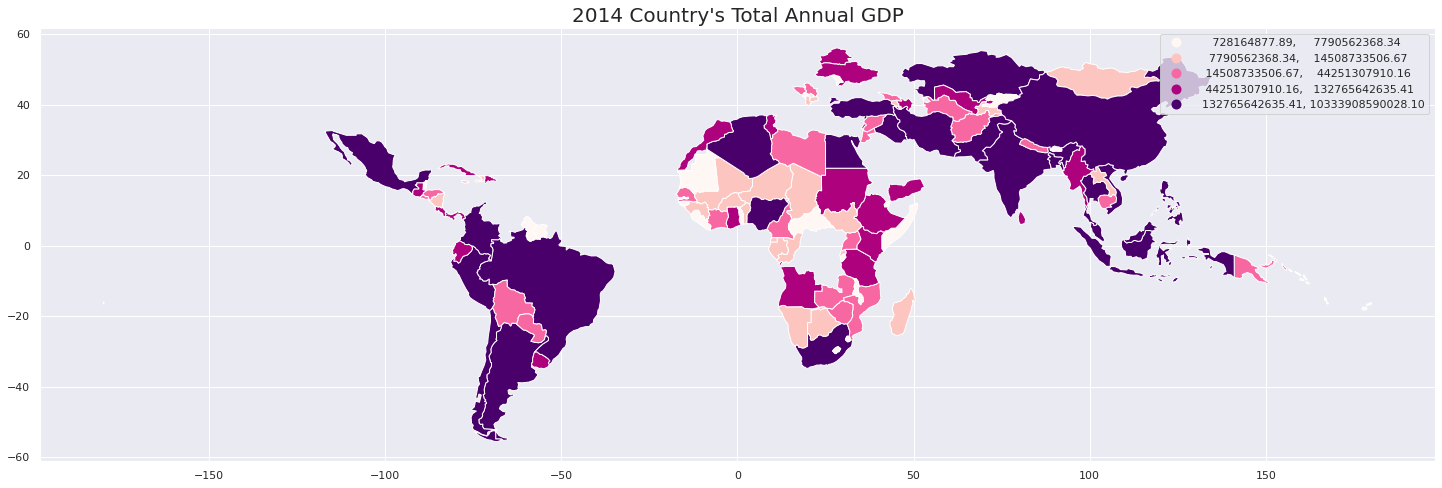

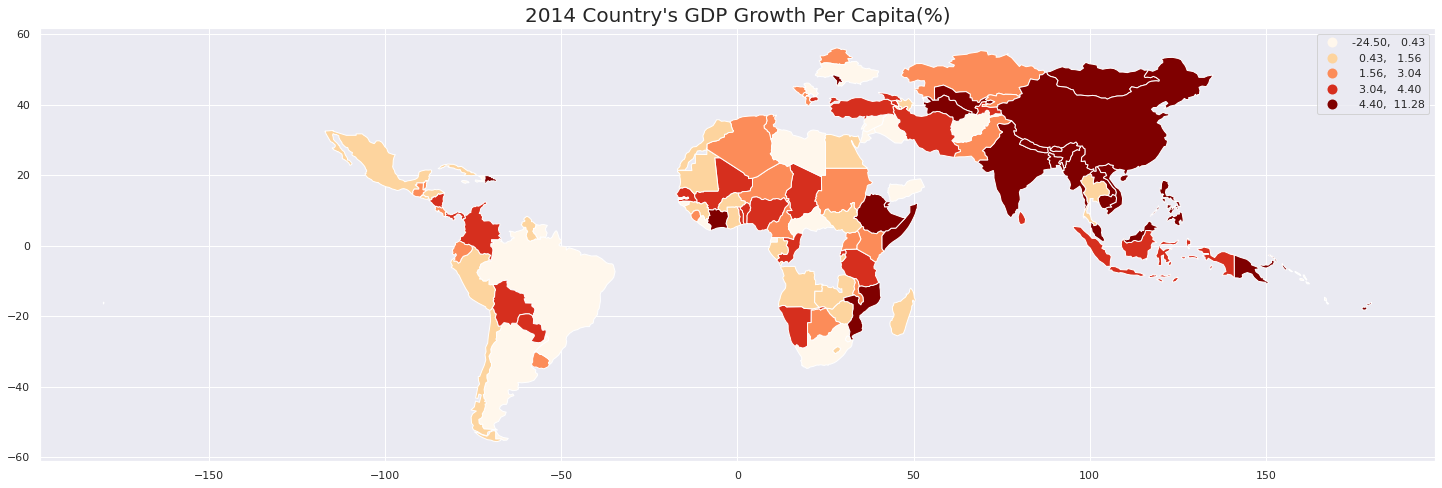

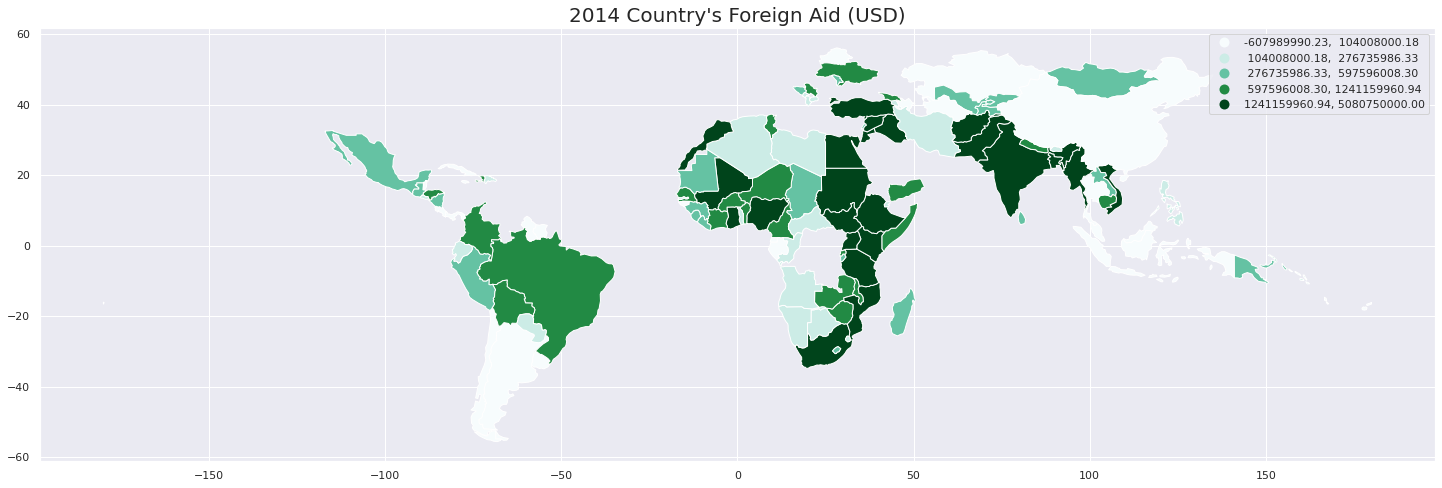

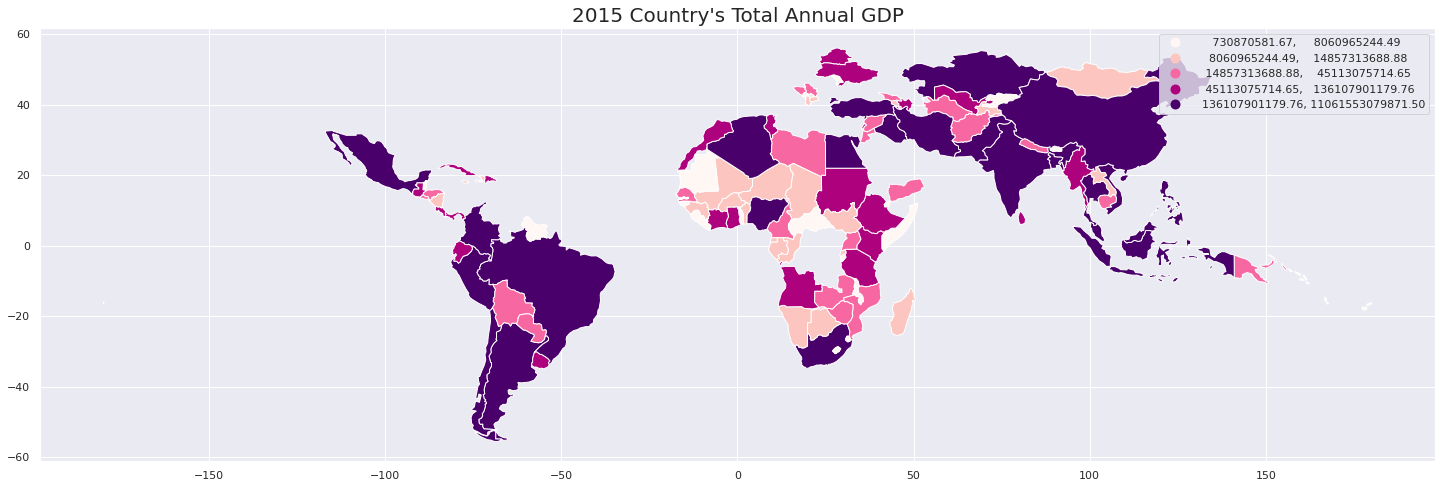

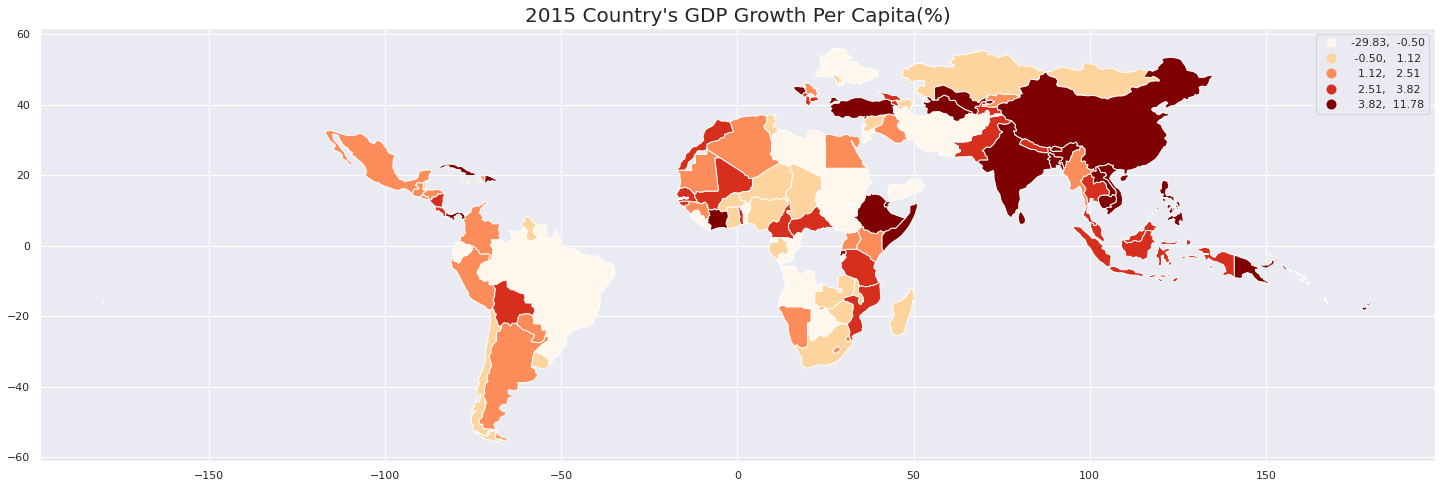

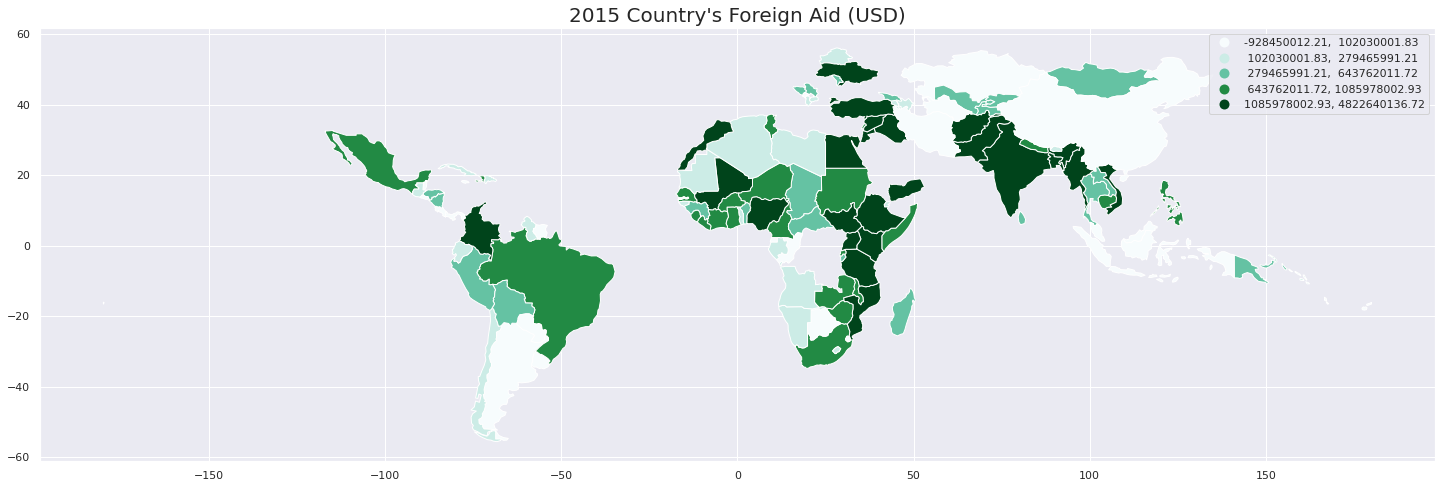

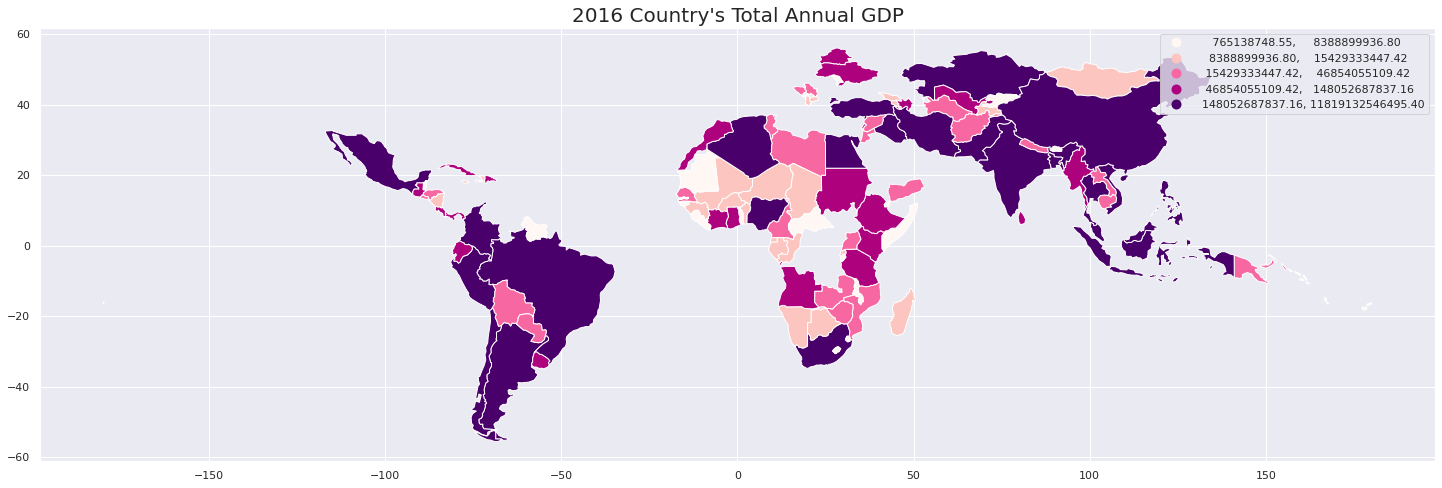

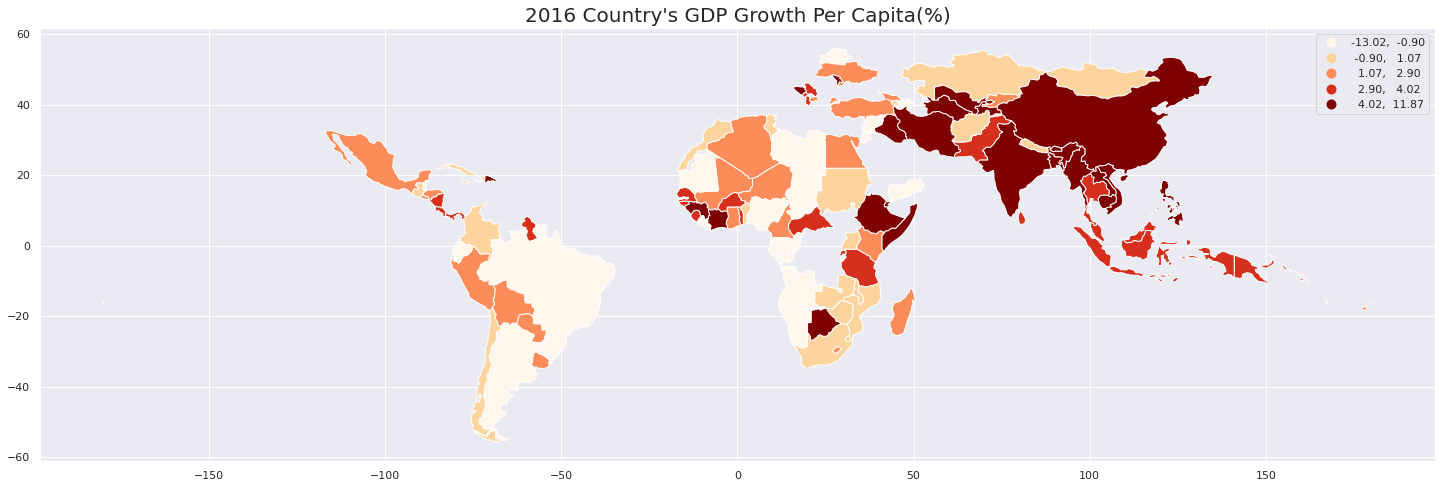

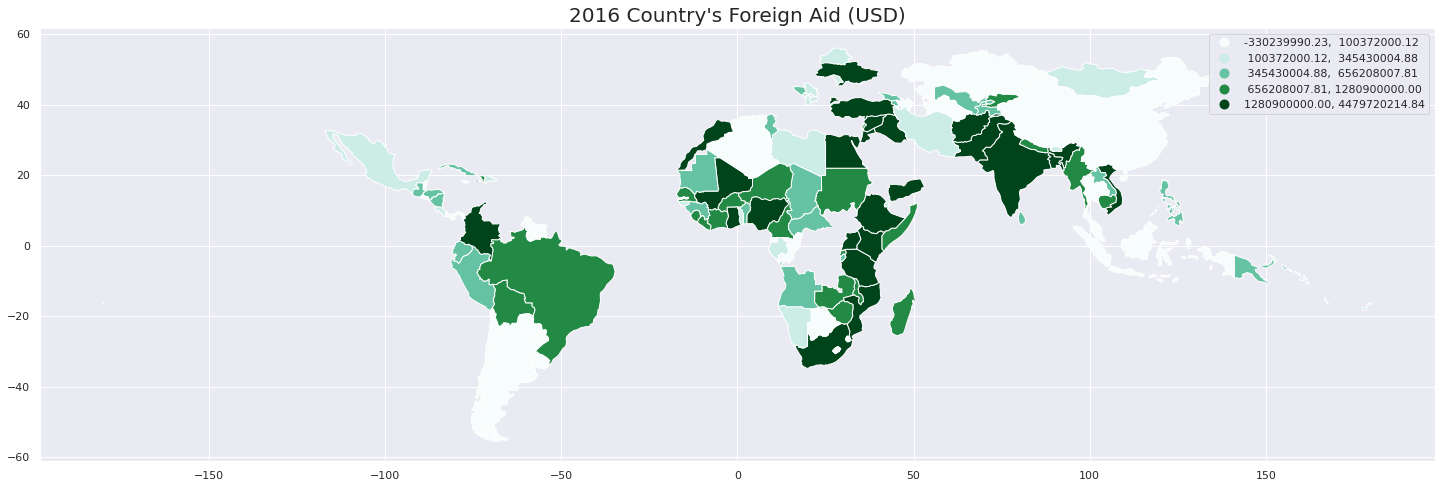

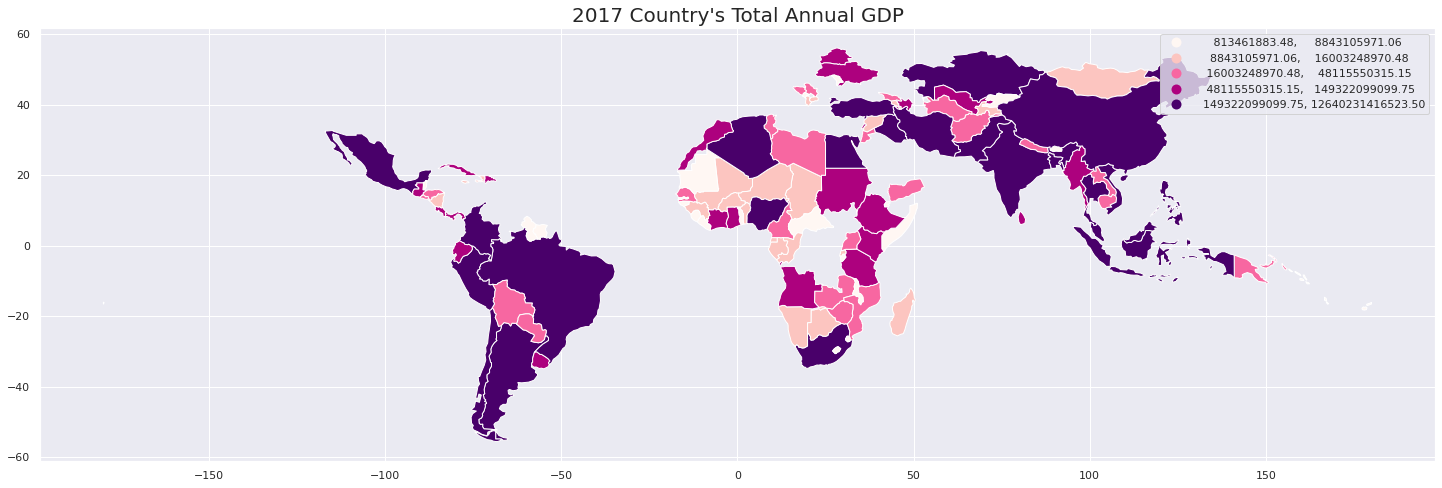

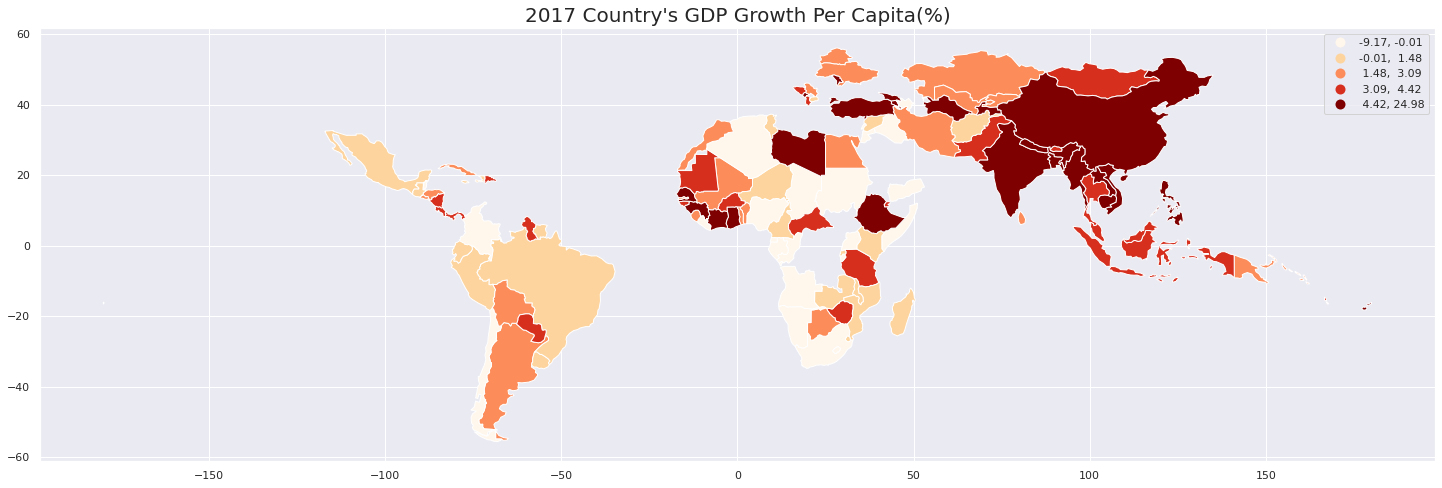

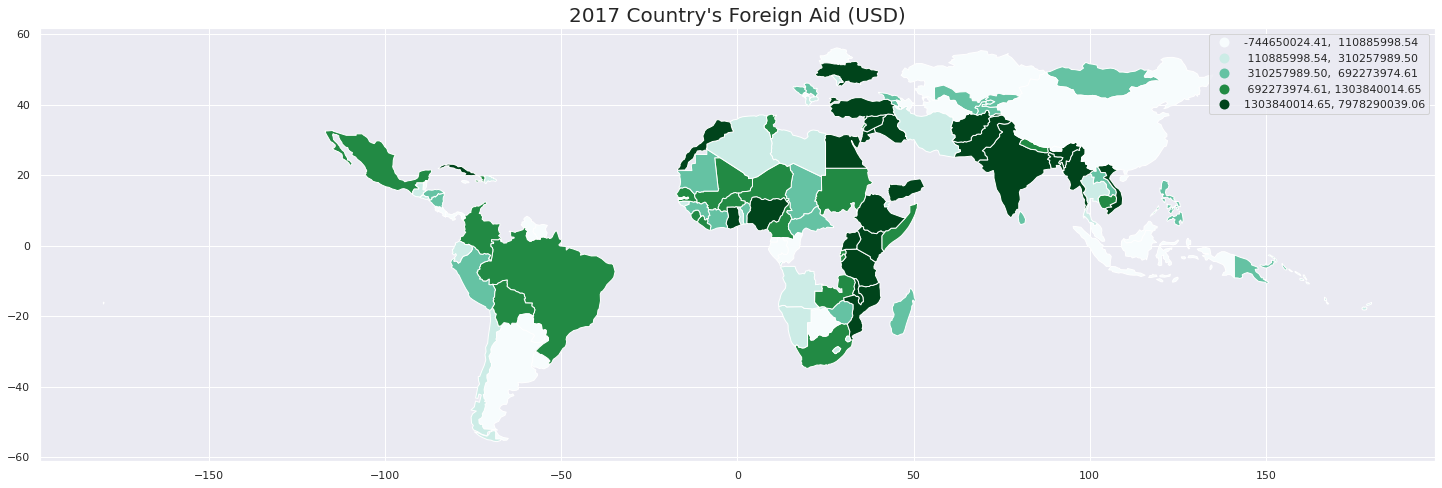

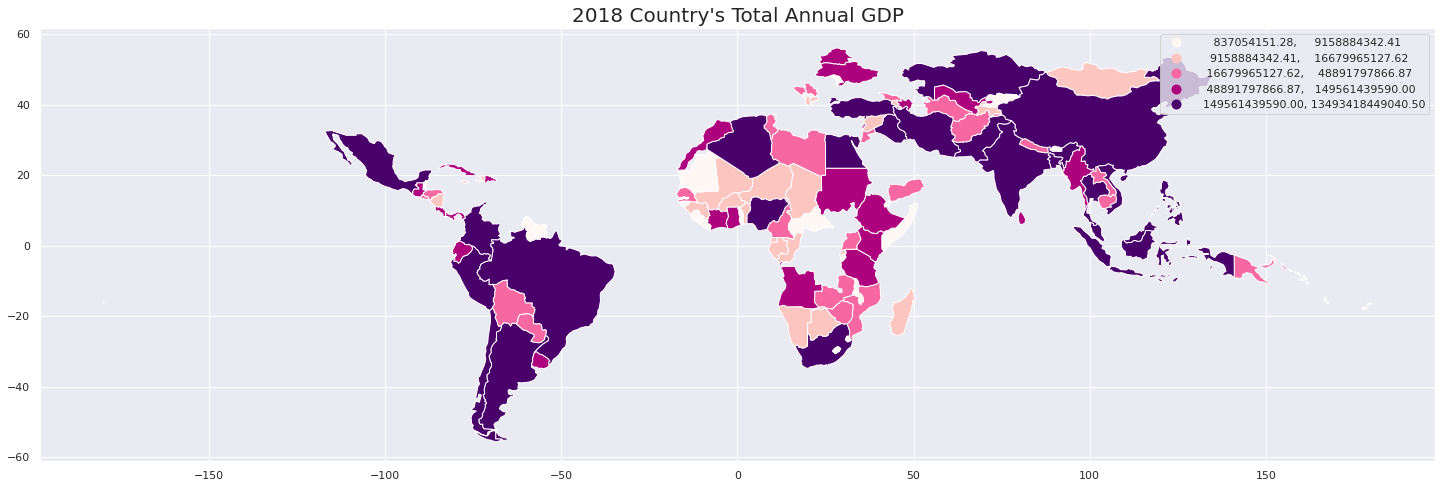

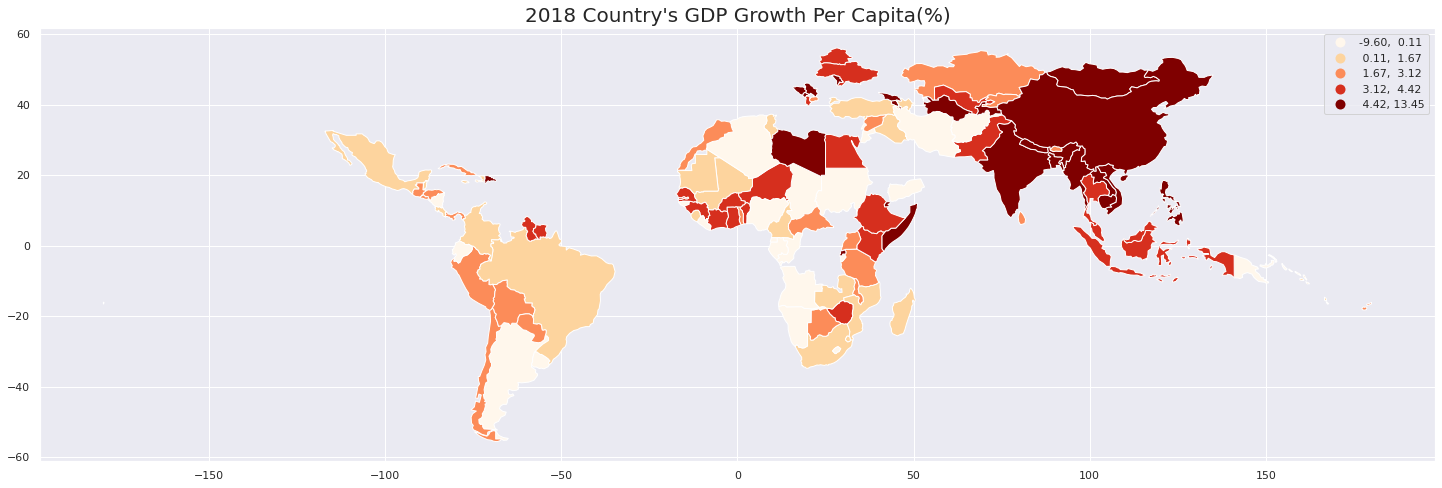

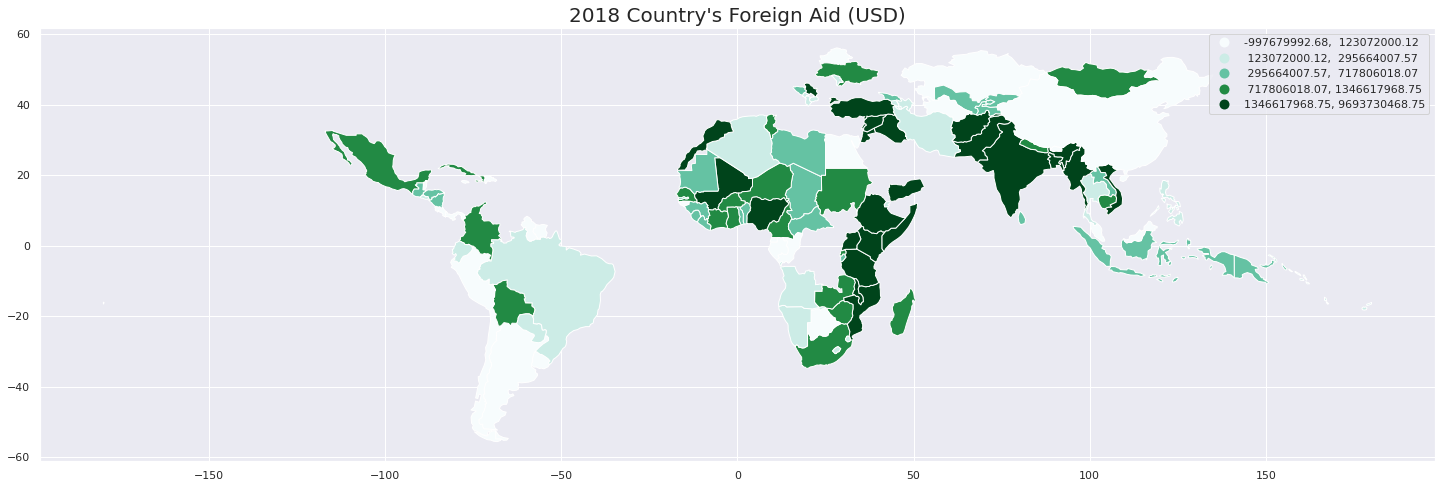

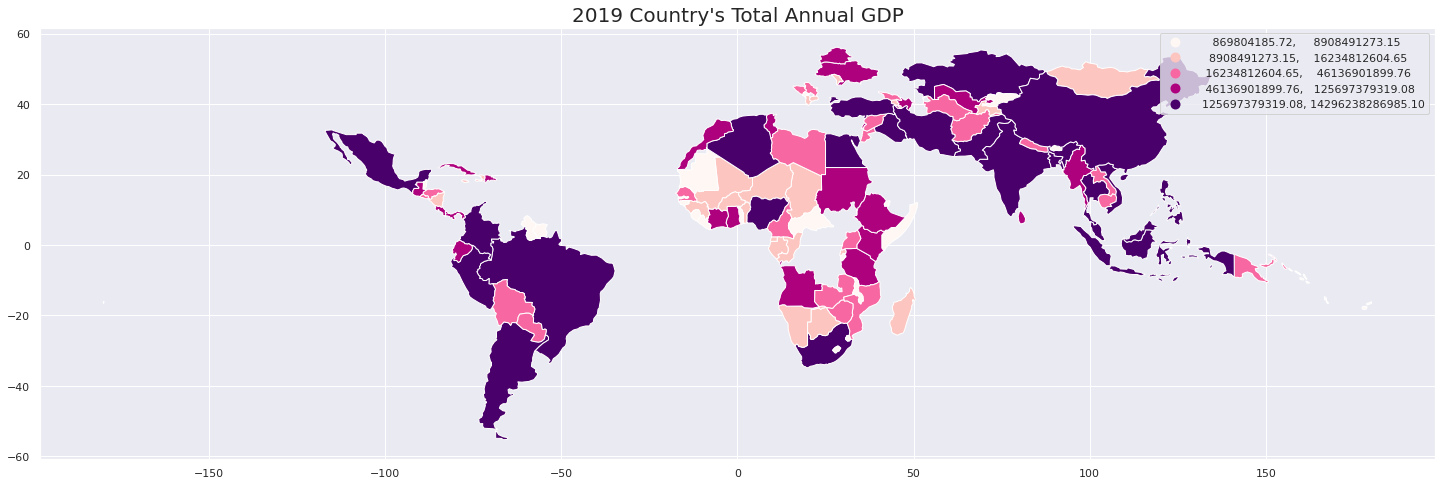

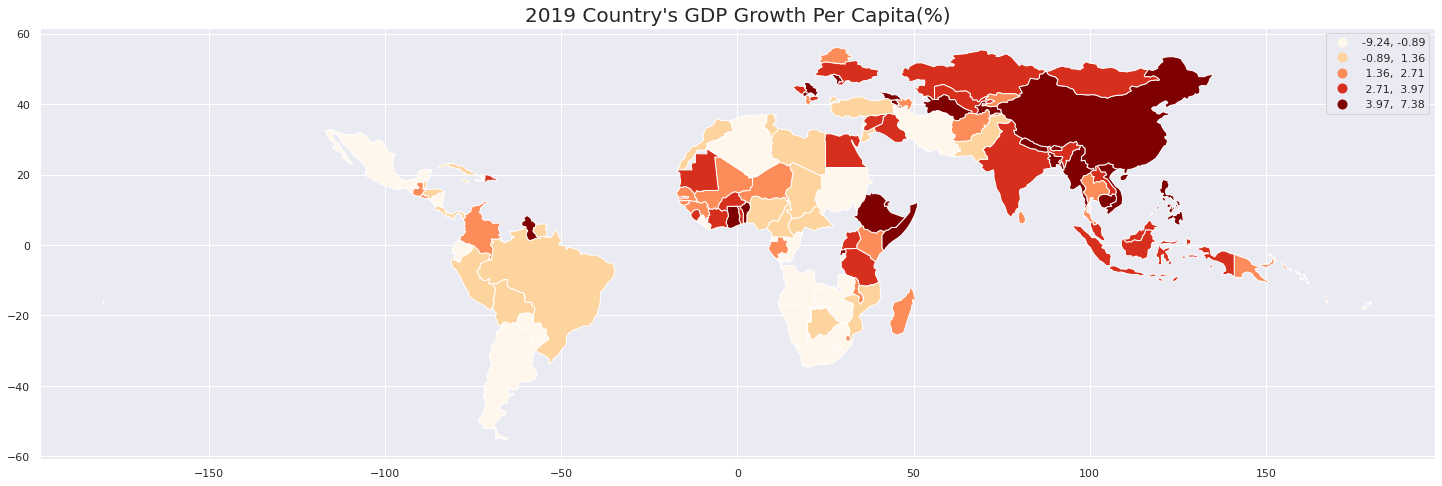

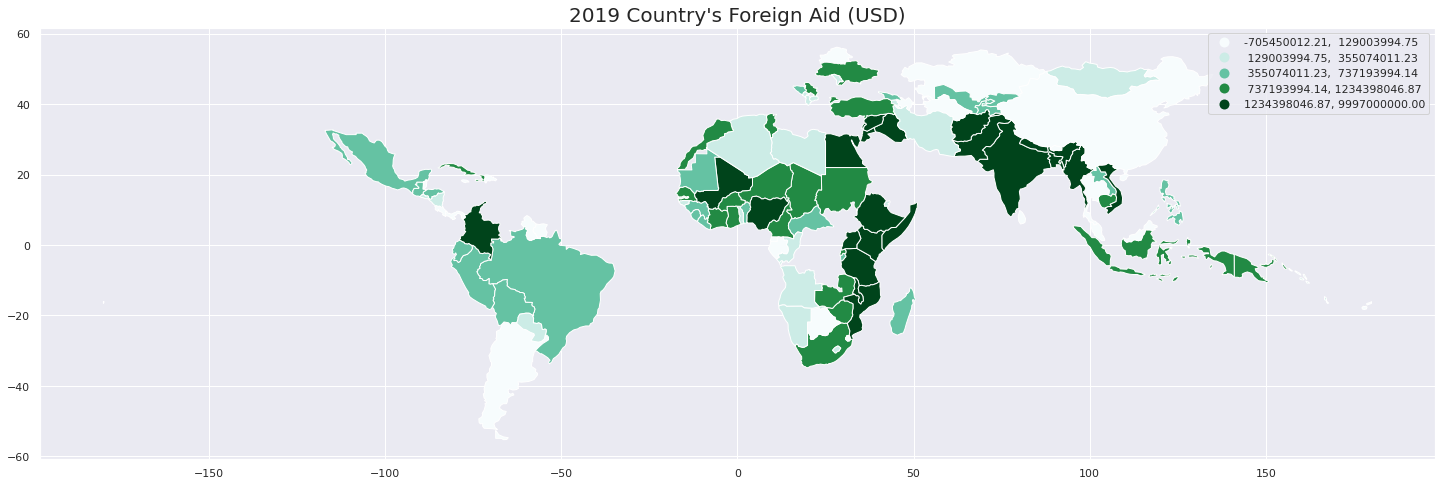

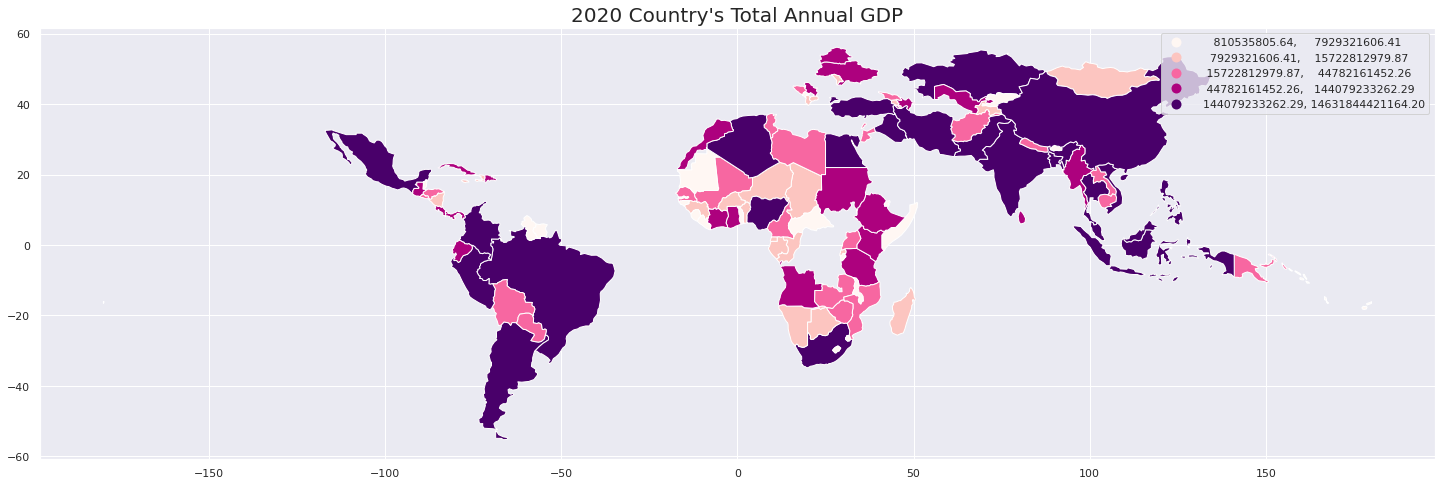

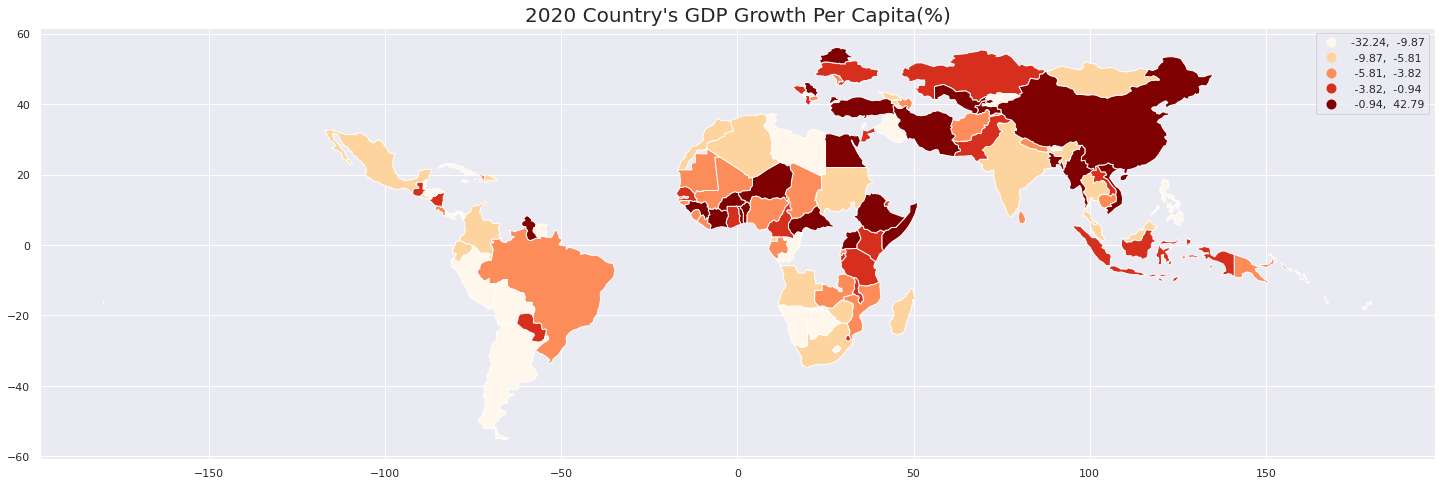

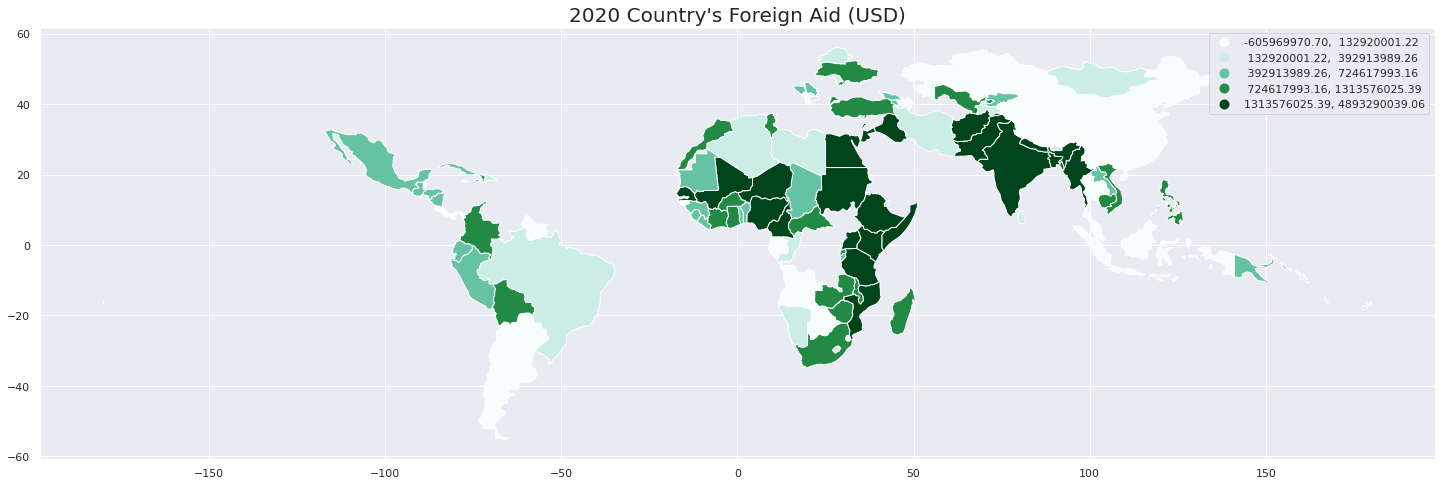

In [374]:
import geopandas
# get world data from geopandas and name the columns
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns=['Population', 'Continent', 'Name', 'Code', 'GeoGDP', 'geometry']

# merge geopanda data with our data
wdf=pd.merge(world,clean_data,on='Code')

# given the data fram and year displays a world map of the gdp and foreign aid for the year
def display_map(df, year):
  gdp_df = df
  # makes data frame only include the given year
  gdp_df = gdp_df[gdp_df['Year']== year]
  # plots the gdp for each country in the data frame
  gdp_df.plot(column='GDP', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='RdPu')
  plt.title(str(year) + ' Country\'s Total Annual GDP',fontsize=20)
  plt.show()


  gdpg_df = df
  # makes data frame only include the given year
  gdpg_df = gdpg_df[gdpg_df['Year']== year]
  # plots the gdp growth for each country in the data frame
  gdpg_df.plot(column='GDP Growth', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='OrRd')
  plt.title(str(year) + ' Country\'s GDP Growth Per Capita(%)',fontsize=20)
  plt.show()

  aid_df = df
  # makes data frame only include the given year
  aid_df = aid_df[aid_df['Year']== year]
  # plots the foreign aid for each country in the data frame
  aid_df.plot(column='Foreign Aid', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='BuGn')
  plt.title(str(year) + ' Country\'s Foreign Aid (USD)',fontsize=20)
  plt.show()

# start and end year of plots being made
start_year = 2010
end_year = 2020

# creates all maps in the given range
for i in range(start_year, end_year + 1):
  display_map(wdf, i)

Based on the maps we see several interestin patters. First, countries that are foreign aid recipients in one year are almost always receiving aid in the folloing period as well. This implies that poor countries stay poor and there is no improvement in their economic performance. Second, countries economic performance in one period has an important effect on the following year. For example, China has had high economic growth level in each year.
Lastly, the maps support our hypothesis that there is no clearly defined relationship between foreign aid and per capita GDP growth rate.

In [375]:
clean_data_filtered = clean_data.copy()
clean_data_filtered = clean_data_filtered[clean_data_filtered['Foreign Aid'] > 0]

###Scatterplot
We create a scatterplot of per capita GDP growth rate and the foreign aid as a percent of total GDP. We also plot a line of best fit. This scatterplot supports our findings from the world map visualizations. There seems to be no relatinship between the two variables.

(0.0, 100.0)

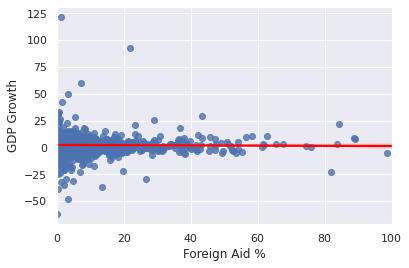

In [376]:
sns.regplot(clean_data_filtered['Foreign Aid %'],clean_data_filtered['GDP Growth'], line_kws={"color": "red"})
plt.xlim(0,100)

### Heatmap
Since economic research shows there might be a relationship between the effectiveness of the foreign aid and the quality of governance in the country we create a correlation heatmap to find the variables that should we control for when testing for the relationship between foreign aid level and the economic performance. 

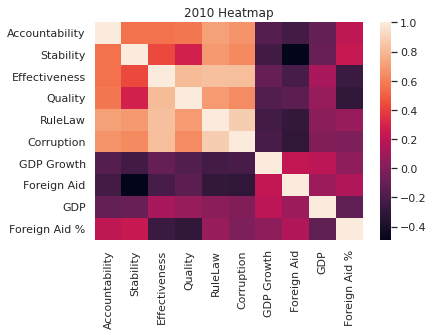

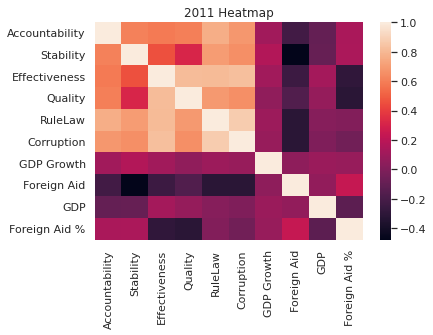

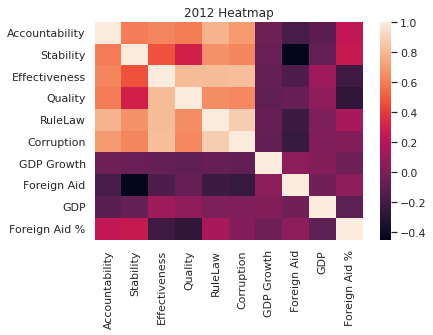

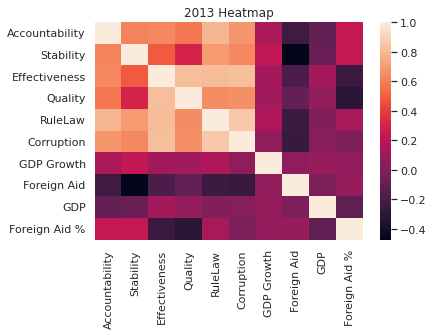

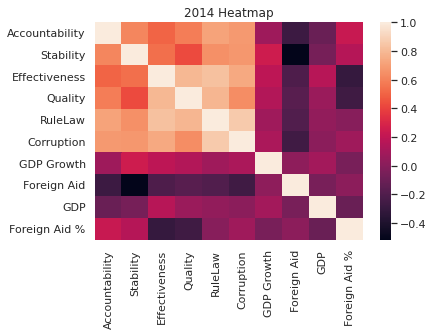

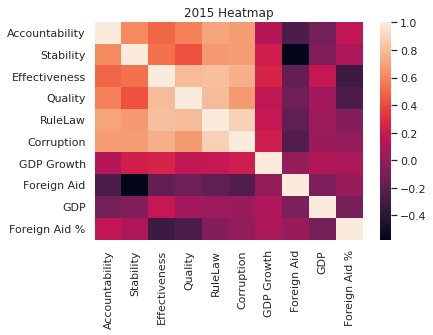

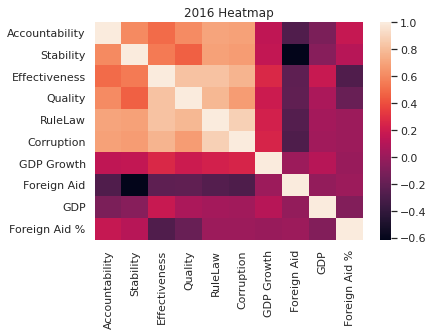

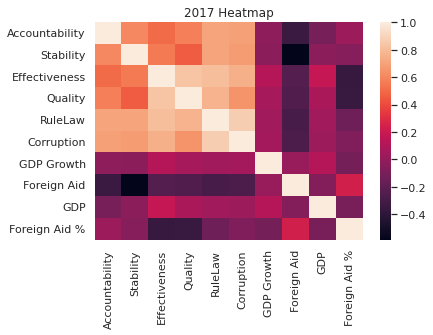

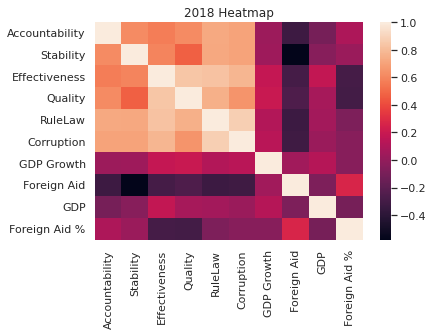

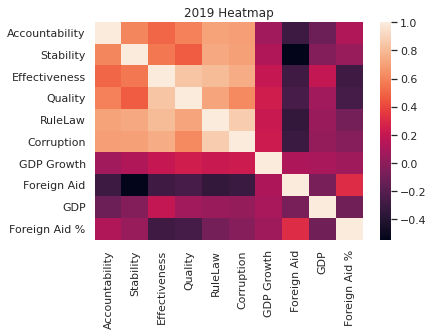

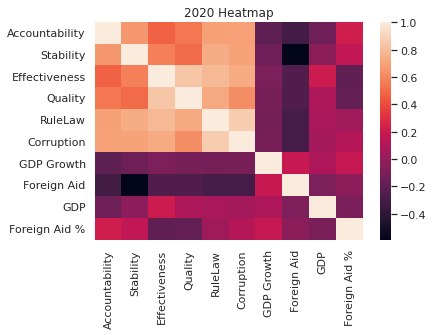

In [377]:
# cleaned data frrame with countries dropped
hmdf = clean_data.drop(columns = ["Country_x"])
# start and end years of heatmaps being made
start = 2010
end = 2020

for i in range(start, end+1):
  plt.figure()
  # gets and drops the year
  year = hmdf[hmdf['Year'] == i]
  year = year.drop(columns = ['Year'])
  # calulates correlation
  correrlation = year.dropna().corr()
  sns.heatmap(correrlation).set(title = f"{i} Heatmap")

The heatmaps look different for each year which implies that there are other factors that affect the relationship between these variables. There is near zero correlation between Foreign Aid and per capita GDP growth rates in most of the years. However, the correlation is stronger between governance indicators and both foreign aid and the ecnomi performance. Countries with worse quality of governance tend to get higher foreign aid levels which makes intuitive sense since they are more likely to have high poverty levels. On the other hand, countries with high level of quality of governance have better economic performances.

#Modeling & Evaluation

To test the effectiveness of the foreign aid in promoting growth, economic development, and prosperity we use logistic regression. We divide countries into three groups based on their level of per capita GDP growth rate. We check how good of a predictor our model is for the economic performance of each country. We use a vector of governance indicators as control variables to ensure that we control for differences in the quality of political and economic institutions.

In [378]:
clean_data_filtered['GDP Growth'].describe(percentiles=[0.2,0.33,0.4,0.6,0.66,0.8])

count    2995.000000
mean        2.294402
std         6.178145
min       -62.378047
20%        -0.488589
33%         1.048045
40%         1.670110
50%         2.568388
60%         3.373154
66%         3.819095
80%         5.282159
max       121.779472
Name: GDP Growth, dtype: float64

Now we create a new variable clssification which shows if country has low, average, or high growth rate in per capita GDP.

In [379]:
# create a list of our conditions

conditions = [
    (clean_data_filtered['GDP Growth'] <= 1.048045),
    (clean_data_filtered['GDP Growth'] > 1.048045) & (clean_data_filtered['GDP Growth'] <= 3.819095),
    (clean_data_filtered['GDP Growth'] > 3.819095)
    ]

#values we want to assign
values = ['Low', 'Average', 'High']


clean_data_filtered['Classification'] = np.select(conditions, values)

We split the data into training and test sets.


In [380]:
X = clean_data_filtered.loc[:, ['Foreign Aid %','Accountability','Stability', 'Effectiveness','Corruption', 'RuleLaw']]
y = clean_data_filtered['Classification']
y = y.squeeze()
#set the random seed
np.random.seed(20)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

Now we look at our data to make sure everything is in correct format.

In [381]:
print("Shape of  X training set: " + str(X_train.shape))
print("Shape of X test set: " + str(X_test.shape))

print("Shape of  y training set: " + str(y_train.shape))
print("Shape of y test set: " + str(y_test.shape))

Shape of  X training set: (2096, 6)
Shape of X test set: (899, 6)
Shape of  y training set: (2096,)
Shape of y test set: (899,)


Now we will train a Softmax Logistic Regression Model.

In [382]:
softmax_reg = LogisticRegression(multi_class='multinomial', random_state = 42, max_iter=1000)
softmax_reg.fit(X_train, y_train)
coef_sogmax=softmax_reg.coef_

Now we generate the confusion matrix and calculate some performance metrics to see how well the SoftMax regression model performed.

              precision    recall  f1-score   support

        High       0.34      0.36      0.35       293
         Low       0.41      0.45      0.42       307
     Average       0.42      0.35      0.39       299

    accuracy                           0.39       899
   macro avg       0.39      0.39      0.39       899
weighted avg       0.39      0.39      0.39       899

Confusion matrix, without normalization
[[105 105  83]
 [109 137  61]
 [ 97  96 106]]
Normalized confusion matrix
[[0.36 0.36 0.28]
 [0.36 0.45 0.2 ]
 [0.32 0.32 0.35]]


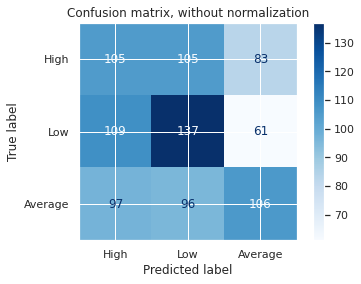

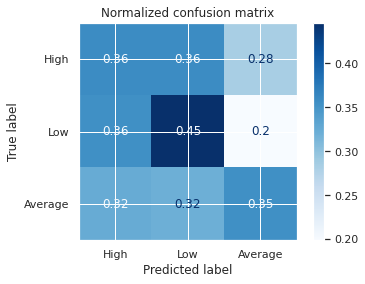

In [383]:
class_names = clean_data_filtered['Classification'].unique()
y_pred=softmax_reg.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(softmax_reg, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Based on the cofusion matrix above we see that our model does not do a great job at classifying the countries based on the per capita GDP growth rate. Each entry in the normalized confusion matrix is close to 0.33. This result is in line with our expectations. As we hypothesised, foreign aid is not effectiveness at promoting growth, economic development, and prosperity.

#Deployment

The goal of our project was to assess the effectiveness of foreign aid in promoting growth, economic development, and prosperity. We used the data from World Bank about each country’s quality of governance, economic performance, and the amount of foreign aid received. Based on our analysis we can make several conclusions. 

First, the quality of governance in the country has an important effect on the performance of the economy. More specifically on the per capita GDP growth rate. This is an important finding, since per capita GDP is flawed but still the best measure of quality of life in a country. We see that to improve the quality and livelihood of people it is crucial to improve the quality of governance, lower the corruption rate, strengthen the rule of law, and make country more democratic. Without strengthening political and economic institutions it will be impossible to promote economic prosperity in the least developed countries. 

Second, our logistic regression showed that foreign aid received as a percent of total GDP is not a good predictor of economic growth in the next period. This is still true after controlling for quality of governance indicators. Thus, the ineffectiveness of the foreign aid is not only due to high corruption level or low government accountability. The ineffectiveness of foreign aid should stem from the way it is distributed or the sector of the economy that is targeted. 

The previous discussion suggests that foreign aid fails to stimulate growth because of reasons related to both recipient and donors. LDCs tend to have low-quality governance and weak institutions, which leads to improper allocation of funds, rent-seeking activities and lowers the incentives to solve collective action problems. On the other hand, donors are reluctant to admit the failure and adjust the aid policy to address the issues. However, a better understanding of both the demand and supply side of the aid can help us design remedial policies. Foreign aid is highly ineffective in the current form, but development organizations can resolve the problem by changing the way the aid is distributed or by making the aid conditional on future reforms. This will ensure that the aid is correctly distributed and also improve the quality of governance in developing nations which is crucial factor for the long-term sustained economic growth and prosperity.

Moving forward, the future research could expand the scale of the data and include more features. It is possible to use other regression methods that could identify important patterns in the data and try to find factors that are cause of the foreign aid's ineffectiveness. Most importantly, future research could use more granular data that contains information about different types of foreign aid that was distributed to least developed countries and the economic sectors that were targeted. This could enable the researchers to find the optimal method of providing foreign aid that promotes economic activity, alleviates provetry, and improves the quality of life of the destitiute. 